<h1> Malaria Forecasting</h1>

In [2]:
from __future__ import division
import numpy as np
import json
import re
import gzip
import pandas as pd
%pylab inline
pylab.rcParams['figure.figsize'] = (12.0, 8.0) # set size of figures"
plt.rcParams.update({'font.size': 24})
import seaborn as sns
import datetime

# for NVD3 plots
#from IPython.html.widgets import *
#from nvd3 import pieChart
#import nvd3
#nvd3.ipynb.initialize_javascript(use_remote=True)

from ethiopian_date import ethiopian_date

pd.set_option('display.max_rows', 50)

Populating the interactive namespace from numpy and matplotlib


In [3]:
DF_ind = pd.read_csv('Malaria_regional_3-15-2017.csv')
# Convert string to datetime
DF_ind['Real_Date'] = pd.to_datetime(DF_ind['Real_Date'])
DF_ind['E_Date'] = pd.to_datetime(DF_ind['E_Date'])
# list of indicator names
ind_names = DF_ind.groupby('Indicator').count().index
ind_names

Index([u'Number of HHs that need LLINs in the last 12 months',
       u'Number of slides or RDT positive for malaria',
       u'Number of slides or RDT positive for malaria 5-14 years: Females',
       u'Number of slides or RDT positive for malaria 5-14 years: Males',
       u'Number of slides or RDT positive for malaria < 5 years: Females',
       u'Number of slides or RDT positive for malaria < 5 years: Males',
       u'Number of slides or RDT positive for malaria >=15 years: Females',
       u'Number of slides or RDT positive for malaria >=15 years: Males',
       u'Number of targeted HHs received at least one LLINs in the last 12 months',
       u'Population',
       u'Proportion of targeted HH covered with LLIN in the last 12 months',
       u'Total number of slides or RDT performed for malaria diagnosis'],
      dtype='object', name=u'Indicator')

<h1> Plotting code </h1>

In [4]:
def pd_proper_dateformat(series):
    '''Given a pandas time series return x, y with the time formatted to plot in matplotlib'''
    return series.index.astype(datetime.datetime), series.values

def frac_err(num, sig_num, den, sig_den):
    return sqrt( (sig_num / den) ** 2 + ((sig_den * num) / (den**2)) ** 2)

def plot_date_indicator(dataframe, indicator, date_type='E_Date', ind2=None, val_name='val'):
    to_plot = dataframe.loc[dataframe['Indicator'] == indicator].reset_index().groupby(['Region', date_type])[val_name].sum()
    ylab_text = indicator    
    #If not none use indicator 2 as the denominator
    if ind2:
        to_plot /= dataframe.loc[dataframe['Indicator'] == ind2].reset_index().groupby(['Region', date_type])[val_name].sum()
        ylab_text = '%s per \n %s' % (indicator, ind2)
        
    start,stop=0,1
    number_of_colors= len(to_plot.index.levels[0])
    cm_subsection = linspace(start, stop, number_of_colors) 
    colors = [ cm.jet(x) for x in cm_subsection ]

    fig=figure()
    fig.set_size_inches(12, 8)
    sns.set_context("notebook", font_scale=2.5, rc={"lines.linewidth": 2.5})

    for level,color in zip(to_plot.index.levels[0],colors):
        x, y = pd_proper_dateformat(to_plot[level])
        plt.plot_date(x, y, '.-', color=color, markersize=20, label=level,)
    ylabel('malaria \n'.join(ylab_text.split('malaria')))
    xlabel('Date')
    legend(loc='upper right', numpoints=1,fontsize=12)
    ax = gca()
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m\n%Y'))
    #ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b'))
    #yscale('log')
    
    return to_plot

def plot_testing(dataframe, indicator, date_type='E_Date', val_name='val', pred_name = 'prediction', train_year = 2007, horz_line = (2007,1), logscale = False, show_leg = True, ylab=None ):
    to_plot = dataframe.loc[dataframe['Indicator'] == indicator].reset_index().groupby(['Region', date_type])[val_name].sum()
    ylab_text = indicator
    
    predict_plot = dataframe.loc[(dataframe['Indicator'] == indicator) & (dataframe['E_year'] > train_year)].reset_index().groupby(['Region', date_type])[pred_name].sum()
    pred_lab_text = pred_name
    #If not none use indicator 2 as the denominator
        
    start,stop=0,1
    number_of_colors= len(to_plot.index.levels[0])
    cm_subsection = linspace(start, stop, number_of_colors) 
    colors = [ cm.jet(x) for x in cm_subsection ]

    fig=figure()
    fig.set_size_inches(12, 8)
    sns.set_context("notebook", font_scale=2.5, rc={"lines.linewidth": 2.5})

    RMSE = []
    for level,color in zip(to_plot.index.levels[0],colors):
        x, y = pd_proper_dateformat(to_plot[level])
        xp, yp = pd_proper_dateformat(predict_plot[level])
        plt.plot_date(x, y, '.-', color=color, markersize=20, label=level,)
        plt.plot_date(xp, yp, '--', color=color, markersize=20, alpha = 0.9)
        
        RMSE.append( (level, sqrt( mean((predict_plot[level] - to_plot[level])**2) ) / mean(to_plot[level]) ) ) 
    
    if ylab:
        ylabel(ylab)
    else:
        ylabel(' malaria\n'.join(ylab_text.split('malaria')))
        
    #xlabel('Date')
    if show_leg:
        legend(loc='upper right', numpoints=1,fontsize=12)
    ax = gca()
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m\n%Y'))
    
    plt.plot_date(['%s-%s-01' % (horz_line), '%s-%s-01' % (horz_line)],[to_plot.min()*0.8, to_plot.max()*1.2],'-', color = 'k')
    
    if logscale:
        plt.yscale('log')
        
    return RMSE

def plot_forcasting(dataframe, df_predict, indicator, val_name='val', train_year = 2007, horz_line = (2007,1) , logscale = False, show_leg = True, ylab=None):
    to_plot = dataframe.loc[dataframe['Indicator'] == indicator].reset_index().groupby(['Region', 'E_Date'])[val_name].sum()
    ylab_text = indicator
    
    predict_plot = df_predict.loc[(df_predict['Indicator'] == indicator) & (df_predict['E_year'] > train_year)].reset_index().groupby(['Region', 'E_Date'])['val'].sum()
    pred_lab_text = 'prediction'
    #If not none use indicator 2 as the denominator
        
    start,stop=0,1
    number_of_colors= len(to_plot.index.levels[0])
    cm_subsection = linspace(start, stop, number_of_colors) 
    colors = [ cm.jet(x) for x in cm_subsection ]

    fig=figure()
    fig.set_size_inches(12, 8)
    sns.set_context("notebook", font_scale=2.5, rc={"lines.linewidth": 2.5})

    RMSE = []
    for level,color in zip(to_plot.index.levels[0],colors):
        x, y = pd_proper_dateformat(to_plot[level])
        xp, yp = pd_proper_dateformat(predict_plot[level])
        plt.plot_date(x, y, '.-', color=color, markersize=20, label=level,)
        plt.plot_date(xp, yp, '--', color=color, markersize=20, alpha = 0.9)
        
        RMSE.append( (level, sqrt( mean((predict_plot[level] - to_plot[level])**2) ) / mean(to_plot[level]) ) ) 
        
    if ylab:
        ylabel(' malaria\n'.join(ylab.split('malaria')))
    else:
        ylabel(' malaria\n'.join(ylab_text.split('malaria')))
        
    #xlabel('Date')
    if show_leg:
        legend(loc='upper right', numpoints=1,fontsize=12)
    ax = gca()
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m\n%Y'))
    
    plt.plot_date(['%s-%s-01' % horz_line, '%s-%s-01' % horz_line],[to_plot.min()*0.8, to_plot.max()*1.2],'-', color = 'k')
    
    if logscale:
        plt.yscale('log')
        
    return RMSE

def plot_testing_nation(dataframe, indicator, date_type='E_Date', val_name='val', pred_name = 'prediction', \
                        train_year = 2007, horz_line = (2007,1), ylab=None, cf_band=False):
    to_plot = dataframe.loc[dataframe['Indicator'] == indicator].reset_index().groupby([date_type])[val_name].sum()
    ylab_text = indicator
    
    predict_plot = dataframe.loc[(dataframe['Indicator'] == indicator) & (dataframe['E_year'] > train_year)].reset_index().groupby([date_type])[pred_name].sum()
    pred_lab_text = pred_name
    #If not none use indicator 2 as the denominator

    fig=figure()
    fig.set_size_inches(12, 8)
    sns.set_context("notebook", font_scale=1.6, rc={"lines.linewidth": 2.5})

    plt.subplot2grid((4,1), (0,0), rowspan=3)
    x, y = pd_proper_dateformat(to_plot)
    xp, yp = pd_proper_dateformat(predict_plot)
    plt.plot_date(x, y, '.-', color='k', markersize=20, label='National Average',)
    plt.plot_date(xp, yp, '--', color='k', markersize=20, label='Prediction', alpha = 0.7)
        
    if ylab:
        ylabel(ylab)
    else:
        ylabel(ylab_text)
        
    #xlabel('Date')
    legend(loc='upper right', numpoints=1, fontsize=12)
    ax = gca()
    #ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m-%Y'))
    #ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m\n%Y'))
    
    plt.plot_date(['%s-%s-01' % horz_line, '%s-%s-01' % horz_line],[to_plot.min()*0.8, to_plot.max()*1.2],'-', color = 'k')
    
    
    # if confidence bands:
    if cf_band:
        predict_upper = dataframe.loc[(dataframe['Indicator'] == indicator) & (dataframe['E_year'] > train_year)].reset_index().groupby([date_type])['prediction_upper'].sum()
        predict_lower = dataframe.loc[(dataframe['Indicator'] == indicator) & (dataframe['E_year'] > train_year)].reset_index().groupby([date_type])['prediction_lower'].sum()
        xp_upper, yp_upper = pd_proper_dateformat(predict_upper)
        xp_lower, yp_lower = pd_proper_dateformat(predict_lower)
        plt.fill_between(xp_upper, yp_lower, yp_upper, alpha = 0.3)
    
    
    # Plot error 
    
    plt.subplot2grid((4,1), (3,0))
    
    #RMSE_n = mean(sqrt((predict_plot - to_plot)**2) / to_plot)
    RMSE_n = sqrt( mean((predict_plot - to_plot)**2) ) / mean(to_plot)
    x, y = pd_proper_dateformat( ((predict_plot - to_plot) * 100 / to_plot).replace(nan,0) )

    plt.plot_date(x, y, '.', color='k', markersize=20, label='percent error',)
    #legend(loc='upper right', numpoints=1,fontsize=12)
    #plt.text(max(x), max(y), 'Norm RMSE = %s' % RMSE_n *100)
    
    ylabel('Percent Error')
    ax = gca()
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m\n%Y'))
    #ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m-%Y'))
    #xlabel('Date')
    
    return to_plot, predict_plot, RMSE_n
    

def plot_forcast_nation(dataframe, df_predict, indicator, val_name='val', train_year = 2007, res=True, ylab=None):
    to_plot = dataframe.loc[dataframe['Indicator'] == indicator].reset_index().groupby(['E_Date'])[val_name].sum()
    ylab_text = indicator
    
    predict_plot = df_predict.loc[(df_predict['Indicator'] == indicator) & (df_predict['E_year'] > train_year)].reset_index().groupby(['E_Date'])['val'].sum()
    pred_lab_text = 'prediction'
    #If not none use indicator 2 as the denominator

    fig=figure()
    fig.set_size_inches(12, 8)
    sns.set_context("notebook", font_scale=1.6, rc={"lines.linewidth": 2.5})

    if res:
        plt.subplot2grid((4,1), (0,0), rowspan=3)
    x, y = pd_proper_dateformat(to_plot)
    xp, yp = pd_proper_dateformat(predict_plot)
    plt.plot_date(x, y, '.-', color='k', markersize=20, label='National Average',)
    plt.plot_date(xp, yp, '--', color='k', markersize=20, label='Prediction', alpha = 0.7)
        
    if ylab:
        ylabel(ylab)
    else:
        ylabel(' malaria\n'.join(ylab_text.split('malaria')))
        
    #xlabel('Date')
    legend(loc='upper right', numpoints=1, fontsize=12)
    ax = gca()
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m-%Y'))
    
    plt.plot_date(['%s-01-01' % (train_year+1), '%s-01-01' % (train_year+1)],[to_plot.min(), to_plot.max()],'-', color = 'k')
    
    RMSE_n = sqrt( mean((predict_plot - to_plot)**2) ) / mean(to_plot)
    # Plot residual errors
    if res:
        plt.subplot2grid((4,1), (3,0))

        x, y = pd_proper_dateformat( ((predict_plot - to_plot) * 100 / to_plot).replace(nan,0) )

        plt.plot_date(x, y, '.', color='k', markersize=20, label='percent error',)
        #legend(loc='upper right', numpoints=1,fontsize=12)
        #plt.text(max(x), max(y), 'Norm RMSE = %s' % RMSE_n *100)

        ylabel('Percent Error')
        ax = gca()
        ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m\n%Y'))
        #ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m-%Y'))
        xlabel('Date')
    
    return to_plot, predict_plot, RMSE_n
    
    
def plot_date_indicator_nation(dataframe, indicator, date_type='E_Date', val_name='val', ind2=None, plt_err=False, plt_mean=False, plt_mean_std=False, x_range=[0,-1], ylab=None):
    to_plot = dataframe.loc[dataframe['Indicator'] == indicator].reset_index().groupby([date_type])[val_name].sum()
    to_plot = to_plot[x_range[0]:x_range[1]]
    yn = to_plot.values
    sqrtNn = sqrt(yn)
    y_err = sqrtNn
    
    if ylab:
        ylab_text = ylab
    else:
        ylab_text = indicator

    #If not none use indicator 2 as the denominator
    if ind2:
        to_plot_d = dataframe.loc[dataframe['Indicator'] == ind2].reset_index().groupby([date_type])[val_name].sum()
        to_plot /= to_plot_d
        yt = to_plot_d.values
        sqrtNt = sqrt(yt)
        y_err = frac_err(yn, sqrtNn, yt, sqrtNt)
        #use binomial error
        p = to_plot.values
        y_err = sqrt( p*(1-p) / yt )
        ylab_text = '%s per \n %s' % (indicator, ind2)
    
    
    fig=figure()
    fig.set_size_inches(12, 8)
    sns.set_context("notebook", font_scale=2.5, rc={"lines.linewidth": 2.5})
    x, y = pd_proper_dateformat(to_plot)
    y_mean = ones_like(y)*mean(y)
    y_mean_err = std(y) / sqrt(len(y))
    plt.plot_date(x, y, '.-', color='k', markersize=20, label='Nation',)
    
    if plt_err:
        plt.fill_between(x, y-y_err, y+y_err,
            alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
            linewidth=4, linestyle='dashdot', antialiased=True, label=r'1 $\sigma$')
        
    if plt_mean:
        plt.plot_date(x, y_mean, '-', color='k', markersize=20, label='Mean',)
    if plt_mean_std:    
        plt.fill_between(x, y_mean-y_mean_err, y_mean+y_mean_err,
        alpha=0.2, edgecolor='black', facecolor='grey',
        linewidth=4, linestyle='dashdot', antialiased=True)
    
    #x has to be in int to fit the data
    x_fit = to_plot.index.astype(int)
    fit = np.poly1d(np.polyfit(x_fit, y, 1))
    y_lin = fit(x_fit)
    plt.plot_date(x, y_lin,'-', color='r', label='Liner Fit',)
    
    ylabel(' malaria\n'.join(ylab_text.split('malaria')))
    #xlabel('Date')
    legend(loc='upper right', numpoints=1,fontsize=12)
    ax = gca()
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m\n%Y'))
    
    return to_plot


In [712]:
def plot_testings_nation(dataframe, indicator, date_type='E_Date', val_name='val', pred_name = 'prediction', \
                         pred_shifts = [0], training_end = 2007, horz_lines = [(2007,1)], ylab=None, cf_band=False, \
                         cmap = cm.Accent, title = 'National'):
    # Setup colors for forecasts:
    start, stop=0, 1
    cm_subsection = linspace(start, stop, len(pred_shifts))
    colors = [cmap(x) for x in cm_subsection]
    
    # Plot the indicator values
    to_plot = dataframe.loc[dataframe['Indicator'] == indicator].reset_index().groupby([date_type])[val_name].sum()
    ylab_text = indicator.split('for')[-1]
    
    fig=figure()
    fig.set_size_inches(12, 8)
    sns.set_context("notebook", font_scale=1.6, rc={"lines.linewidth": 2.5})

    plt.subplot2grid((4,1), (0,0), rowspan=3)
    x, y = pd_proper_dateformat(to_plot)
    plt.plot_date(x, y, '.-', color='k', markersize=20, label=title,)
    plt.title(title)
    
    # Plot the predictions
    for i, mshift in enumerate(pred_shifts):
        # add postfix to prediction name
        date_min = pd.datetime(training_end[0], training_end[1], 1) - pd.offsets.relativedelta(months=mshift)
        pred_str = pred_name
        if mshift > 0:
            pred_str = '%s_m_%s' % (pred_name, mshift)
        predict_plot = dataframe.loc[(dataframe['Indicator'] == indicator) \
            & (dataframe['E_Date'] > date_min)].reset_index().groupby([date_type])[pred_str].sum()
        pred_lab_text = pred_str
        xp, yp = pd_proper_dateformat(predict_plot)
        plt.plot_date(xp, yp, '--', color=colors[i], markersize=20, label=pred_str, alpha = 0.9)
        
    if ylab:
        ylabel(ylab)
    else:
        ylabel(ylab_text)
        
    #xlabel('Date')
    legend(loc='upper right', numpoints=1, fontsize=12)
    ax = gca()
    # Remove x labels
    ax.tick_params(labelbottom='off')
    #ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m-%Y'))
    #ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m\n%Y'))
    
    # Add horizontal lines:
    for i, horz_line in enumerate(horz_lines):
        plt.plot_date(['%s-%s-01' % horz_line, '%s-%s-01' % horz_line],[to_plot.min()*0.8, to_plot.max()*1.2],\
                      '-', color = colors[i])
    
    
    # if confidence bands:
    if cf_band:
        for i, mshift in enumerate(pred_shifts):
            date_min = pd.datetime(training_end[0], training_end[1], 1) - pd.offsets.relativedelta(months=mshift)
            # add postfix to prediction name
            pred_up_str = '%s_upper' % pred_name
            pred_low_str = '%s_lower' % pred_name
            if mshift > 0:
                pred_up_str = '%s_m_%s' % (pred_up_str, mshift)
                pred_low_str = '%s_m_%s' % (pred_low_str, mshift)

            predict_upper = dataframe.loc[(dataframe['Indicator'] == indicator) & (dataframe['E_Date'] > date_min)].reset_index().groupby([date_type])[pred_up_str].sum()
            predict_lower = dataframe.loc[(dataframe['Indicator'] == indicator) & (dataframe['E_Date'] > date_min)].reset_index().groupby([date_type])[pred_low_str].sum()
            xp_upper, yp_upper = pd_proper_dateformat(predict_upper)
            xp_lower, yp_lower = pd_proper_dateformat(predict_lower)
            plt.fill_between(xp_upper, yp_lower, yp_upper, color = colors[i], alpha = 0.1)
     
    
    plt.subplot2grid((4,1), (3,0))
    
    #RMSE_n = mean(sqrt((predict_plot - to_plot)**2) / to_plot)
    RMSE_n = sqrt( mean((predict_plot - to_plot)**2) ) / mean(to_plot)
    x, y = pd_proper_dateformat( ((predict_plot - to_plot) * 100 / to_plot).replace(nan,0) )

    plt.plot_date(x, y, '.', color='k', markersize=20, label='percent error',)
    #legend(loc='upper right', numpoints=1,fontsize=12)
    #plt.text(max(x), max(y), 'Norm RMSE = %s' % RMSE_n *100)
    
    ylabel('Percent Error')
    ax = gca()
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b\n%Y'))
    #ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m-%Y'))
    #xlabel('Date')
    
    return to_plot, predict_plot, RMSE_n

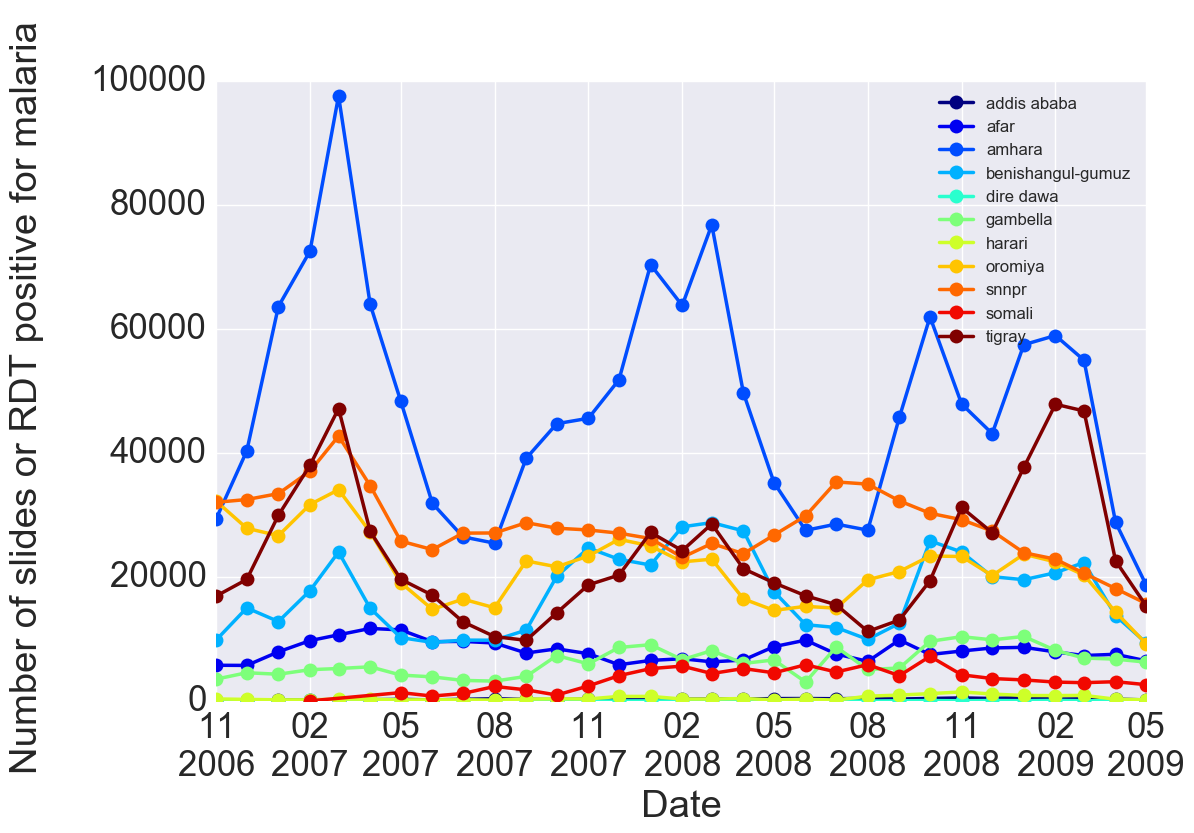

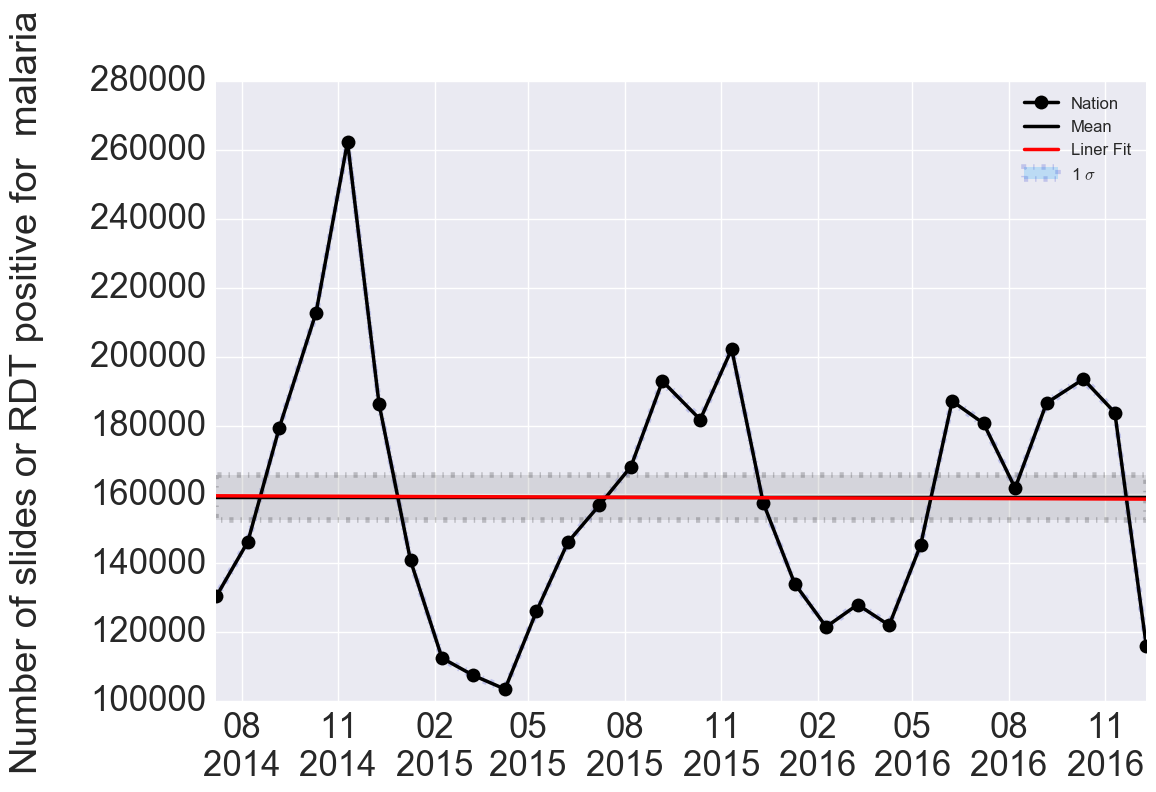

In [6]:
indicator = 'Number of slides or RDT positive for malaria'
#indicator = ind_names[3]
series_d = plot_date_indicator(DF_ind, indicator)
series_d = plot_date_indicator_nation(DF_ind, indicator, date_type='Real_Date', plt_mean=True, plt_err=True, plt_mean_std=True, x_range=[0,-1])

<h1> Setup predictive model </h1>

<h1> For prediction only use certain indicator names in the data set </h1>

<h3> Here you use all dissaggregations of malaria count. <br> make this into two seperate notebooks </h3>

In [577]:
indicator = 'Number of slides or RDT positive for malaria'

# use this for malaria rate forecasting (need to update for gender)
indicator_cut = [indicator in ind_name for ind_name in DF_ind['Indicator']]
#use this for general forecasting
#indicator_cut = [ind_name in set(ind_names) for ind_name in DF_ind['Indicator']]

#build a new dataframe from the indicator cut on the original one
#DF_shift = pd.DataFrame(DF_ind.loc[DF_ind['Indicator'].isin set(ind_names)])

DF_shift = pd.DataFrame(DF_ind.loc[indicator_cut])

In [578]:
indicators = DF_shift.groupby('Indicator').count().index
indicators

Index([u'Number of slides or RDT positive for malaria',
       u'Number of slides or RDT positive for malaria 5-14 years: Females',
       u'Number of slides or RDT positive for malaria 5-14 years: Males',
       u'Number of slides or RDT positive for malaria < 5 years: Females',
       u'Number of slides or RDT positive for malaria < 5 years: Males',
       u'Number of slides or RDT positive for malaria >=15 years: Females',
       u'Number of slides or RDT positive for malaria >=15 years: Males'],
      dtype='object', name=u'Indicator')

<h1> rename variables for old convention </h1>

In [579]:
DF_shift['prec_mm'] = DF_shift['ave_prec_mm']
DF_shift['temp'] = DF_shift['ave_temp']

<h1> add leading indicators </h1>

In [580]:
#DF_shift['val'] = DF_shift['val'] / DF_shift['val'].max()
DF_shift['val_shift_1'] = DF_shift.shift(1)['val']
#DF_shift['val_delta'] = (DF_shift['val'] - DF_shift['val_shift_1']) / DF_shift['val_shift_1']
DF_shift['infection_rate_shift_1'] = DF_shift.shift(1)['infection_rate']
DF_shift['temp_shift_1'] = DF_shift.shift(1)['temp']
DF_shift['prec_shift_1'] = DF_shift.shift(1)['prec_mm']
DF_shift['Region_shift_1'] = DF_shift.shift(1)['Region']
DF_shift['Ind_shift_1'] = DF_shift.shift(1)['Indicator']

#only makes sense when considering historical averages
DF_shift['temp_delta'] = DF_shift['temp'] - DF_shift['temp_shift_1']
DF_shift['prec_delta'] = DF_shift['prec_mm'] - DF_shift['prec_shift_1']

DF_shift['val_shift_2'] = DF_shift.shift(2)['val']
DF_shift['infection_rate_shift_2'] = DF_shift.shift(2)['infection_rate']
DF_shift['temp_shift_2'] = DF_shift.shift(2)['temp']
DF_shift['prec_shift_2'] = DF_shift.shift(2)['prec_mm']
DF_shift['Region_shift_2'] = DF_shift.shift(2)['Region']
DF_shift['Ind_shift_2'] = DF_shift.shift(2)['Indicator']

DF_shift['temp_delta_2'] = DF_shift['temp_shift_1'] - DF_shift['temp_shift_2']
DF_shift['prec_delta_2'] = DF_shift['prec_shift_1'] - DF_shift['prec_shift_2']

#val delta can not rely on the upcoming prediction. Only makes sense to go two back
DF_shift['val_delta'] = (DF_shift['val_shift_1'] - DF_shift['val_shift_2']) / DF_shift['val_shift_2']
DF_shift['infection_rate_delta'] = (DF_shift['infection_rate_shift_1'] - DF_shift['infection_rate_shift_2']) / DF_shift['infection_rate_shift_2']

<h1> log of indicators </h1>

In [581]:
DF_shift['log_val'] = np.log10(DF_shift['val']).replace(nan, 1/100)
DF_shift['log_val_delta'] = np.log10(DF_shift['val_delta']).replace(nan, 1/100).replace(-inf, 1/1000)
DF_shift['log_val_shift_1'] = np.log10(DF_shift['val_shift_1']).replace(nan, 1/100).replace(-inf, 1/1000)
DF_shift['log_val_shift_2'] = np.log10(DF_shift['val_shift_2']).replace(nan, 1/100).replace(-inf, 1/1000)

DF_shift['log_infection_rate'] = np.log10(DF_shift['infection_rate']).replace(nan, 1/100).replace(-inf, 1/1000)
DF_shift['log_infection_rate_shift_1'] = np.log10(DF_shift['infection_rate_shift_1']).replace(nan, 1/100).replace(-inf, 1/1000)

DF_shift['log_elevation_m'] = np.log10(DF_shift['elevation_m']).replace(nan, 1/100)
DF_shift['log_pop'] = np.log10(DF_shift['pop']).replace(nan, 1/100)
DF_shift['log_density'] = np.log10(DF_shift['density']).replace(nan, 1/100)

DF_shift['log_prec_mm'] = np.log10(DF_shift['prec_mm']).replace(nan, 1/100).replace(-inf, 1/1000)
DF_shift['log_prec_shift_1'] = np.log10(DF_shift['prec_shift_1']).replace(nan, 1/100).replace(-inf, 1/1000)
DF_shift['log_prec_shift_2'] = np.log10(DF_shift['prec_shift_2']).replace(nan, 1/100).replace(-inf, 1/1000)

DF_shift['log_prec_delta'] = np.log10(DF_shift['prec_delta']).replace(nan, 1/100).replace(-inf, 1/1000)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in log10


<h3> clean up nan and region missmatch. Require the region and the indicator to be the same </h3>

In [582]:
DF_shift = DF_shift.loc[(DF_shift['Region'] == DF_shift['Region_shift_1']) &\
                      (DF_shift['Indicator'] == DF_shift['Ind_shift_1']) &\
                      (DF_shift['Region'] == DF_shift['Region_shift_2']) &\
                      (DF_shift['Indicator'] == DF_shift['Ind_shift_2']) ]


In [583]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
#from sklearn.preprocessing import OneHotEncoder
#RF = RandomForestRegressor()
RF = GradientBoostingRegressor(learning_rate=.1, n_estimators=1000)


<h1> Model the infection rate (cases normalized to population) </h1>

<h3> Split the data set into training t <= 2007 and validation t > 2008 </h3>

In [30]:
#train on 2007 data
DF_training = pd.DataFrame(DF_shift.loc[DF_shift['E_year'] <= 2007])

#all data
#DF_training = DF_shift

In [31]:
# labels:
y = DF_training.infection_rate.values


features = ['pop', 'density', 'month', 'net_frac', 'elevation_m', 'temp', 'prec_mm', 'temp_delta', 'prec_delta', \
        'val_delta', 'gen_cat', 'age_cat', 'infection_rate_shift_1', 'infection_rate_shift_2', 'infection_rate_delta',\
        'val_shift_1', 'val_shift_2', 'temp_shift_1', 'prec_shift_1', 'temp_shift_2', 'prec_shift_2']


#log_features = ['log_pop','log_density','month', 'net_frac', 'log_elevation_m', 'temp', 'log_prec_mm', 'temp_delta',\
#            'log_prec_delta', 'log_val_delta', 'gen_cat', 'age_cat', \
#            'log_infection_rate_shift_1', 'log_val_shift_1', 'log_val_delta',\
#            'temp_shift_1', 'log_prec_shift_1','log_val_shift_2', 'temp_shift_2', 'log_prec_shift_2']

# features
x = DF_training[features].values

# Fitting
RF.fit(x,y)

#Make predictions beyond 2007 to compare with data in 2008
x_all = DF_shift[features].values
prediction = RF.predict(x_all)

DF_shift['prediction'] = prediction

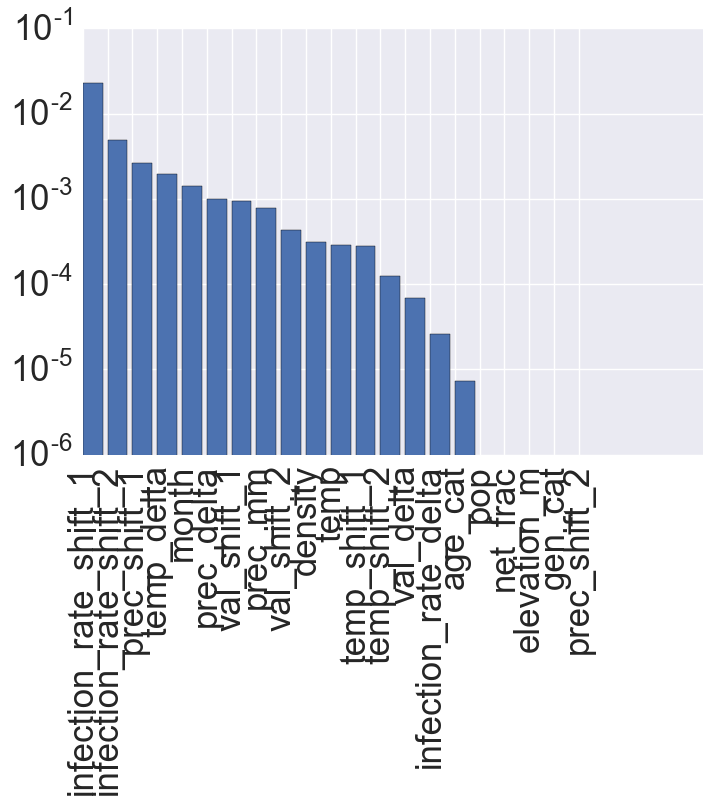

In [32]:
feature_imp = RF.feature_importances_
sorted_index = sorted(range(len(feature_imp)),key=lambda x:feature_imp[x], reverse=True)

x = range(len(feature_imp))
plt.bar(x, feature_imp[sorted_index])
xticks(x, [features[i] for i in sorted_index], rotation = 'vertical')
yscale('log')

In [33]:
indicator = 'Number of slides or RDT positive for malaria'
#series_d = plot_date_indicator(DF_ind, indicator, val_name='infection_rate')
#series_p = plot_date_indicator(DF_shift, indicator, val_name='prediction')

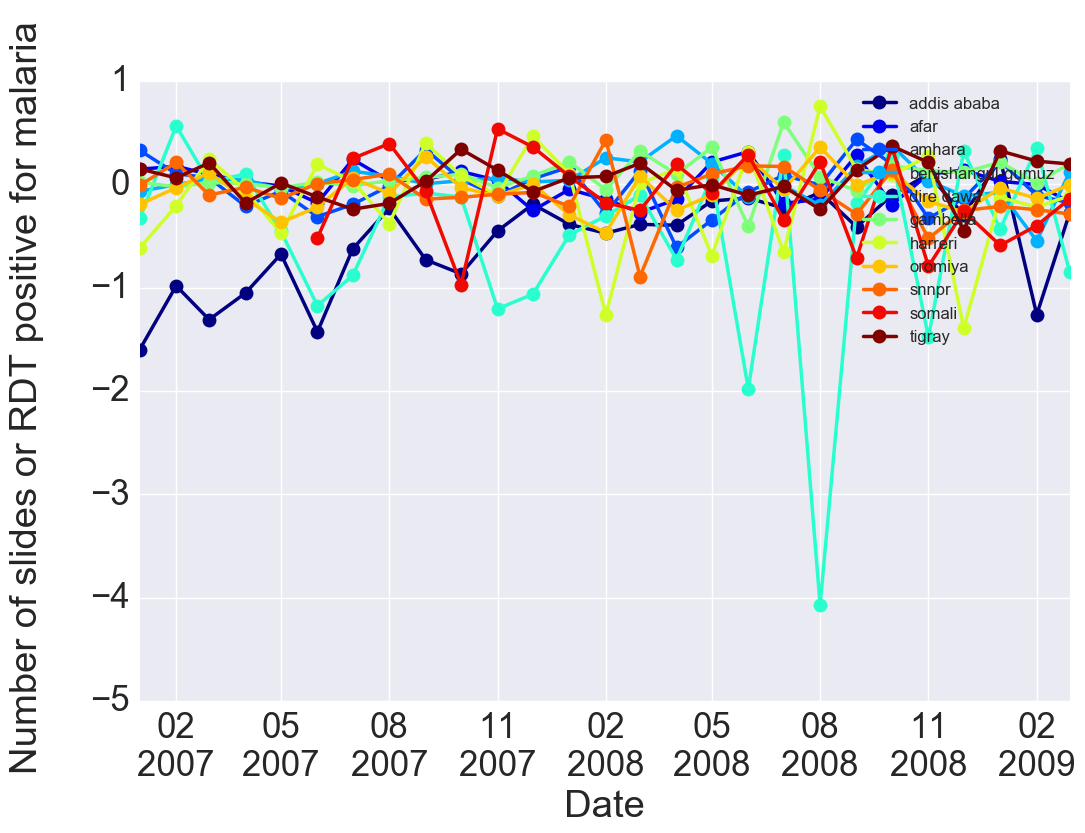

In [34]:
DF_shift['diff'] = DF_shift['infection_rate']-DF_shift['prediction']
DF_shift['norm_diff'] = (DF_shift['infection_rate']-DF_shift['prediction']) / DF_shift['infection_rate']
DF_shift['mse'] = (DF_shift['infection_rate']-DF_shift['prediction']) ** 2
series_d = plot_date_indicator(DF_shift, indicator, val_name='norm_diff')

In [35]:
sqrt(mean((DF_shift['infection_rate']-DF_shift['prediction'])**2))/mean(DF_shift['infection_rate'])

0.61183230562128499

In [36]:
sqrt(DF_shift.groupby('Region').mse.mean()) / DF_shift.groupby('Region').infection_rate.mean()*100

Region
addis ababa          401.181002
afar                  24.246263
amhara                39.063925
benishangul-gumuz     35.091861
dire dawa            231.090786
gambella              40.793470
harreri               93.633446
oromiya               43.092510
snnpr                 37.590315
somali                61.493512
tigray                36.044365
dtype: float64

<h1> plot forecast in 2008 with actual data</h1>

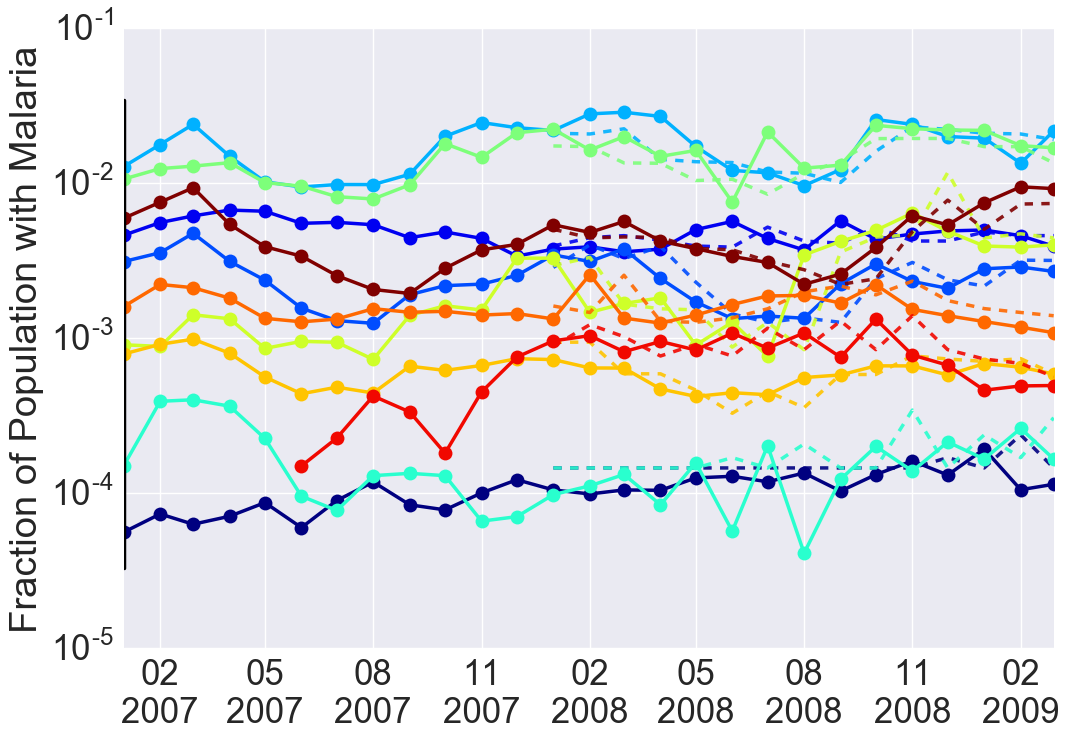

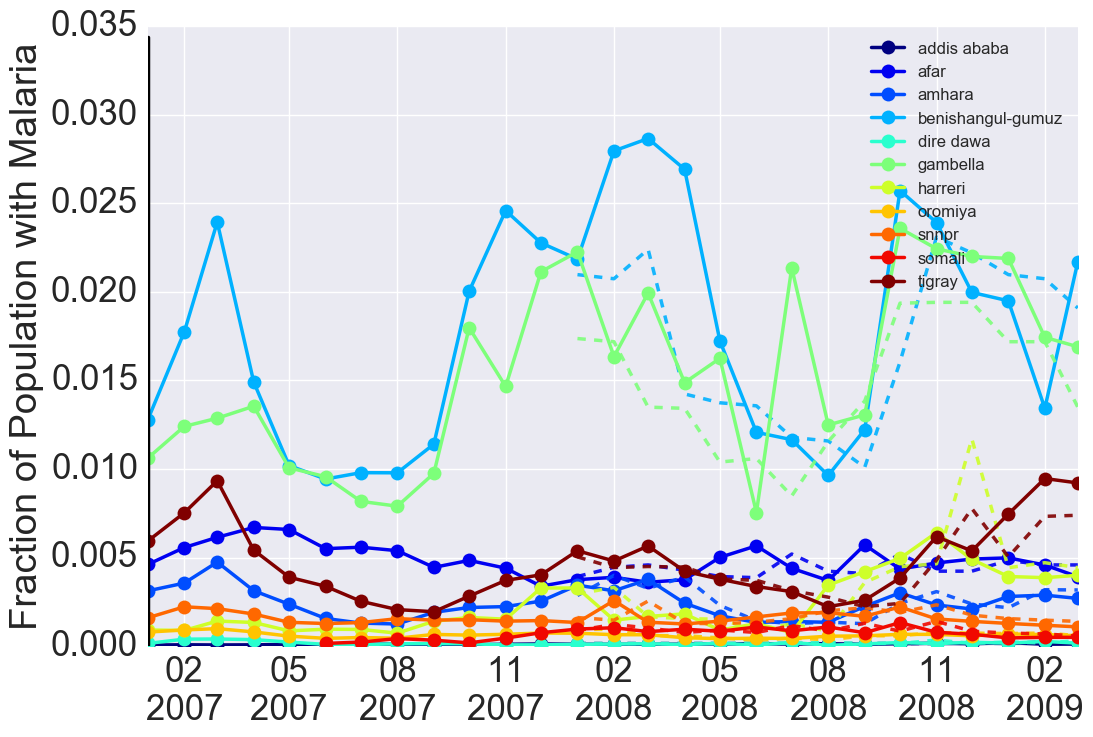

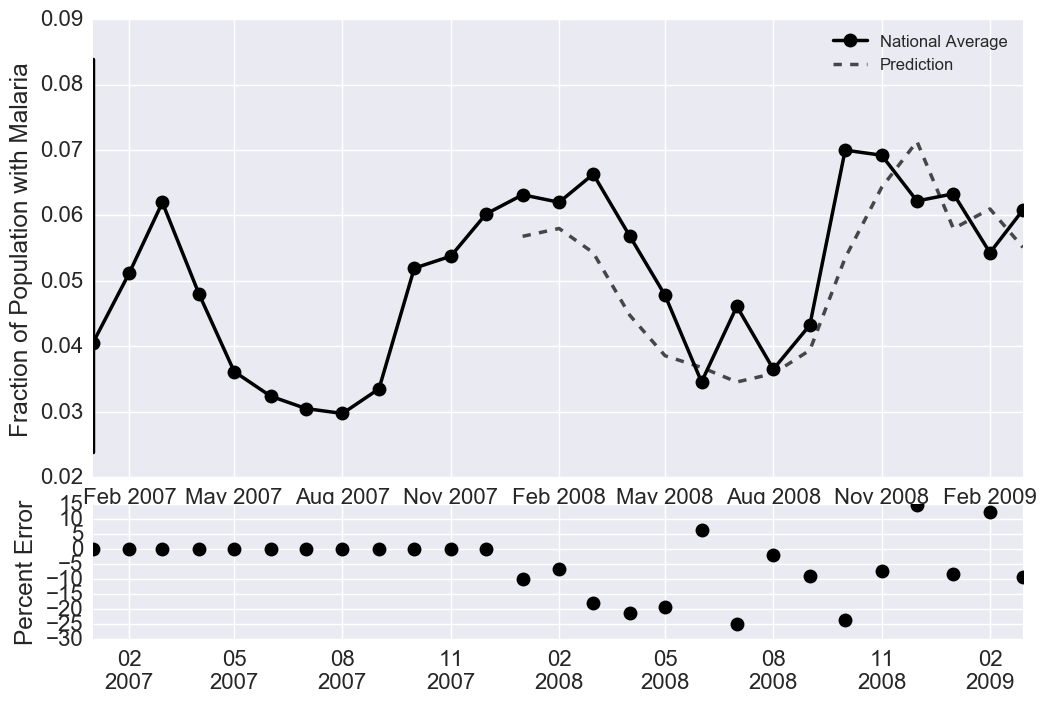

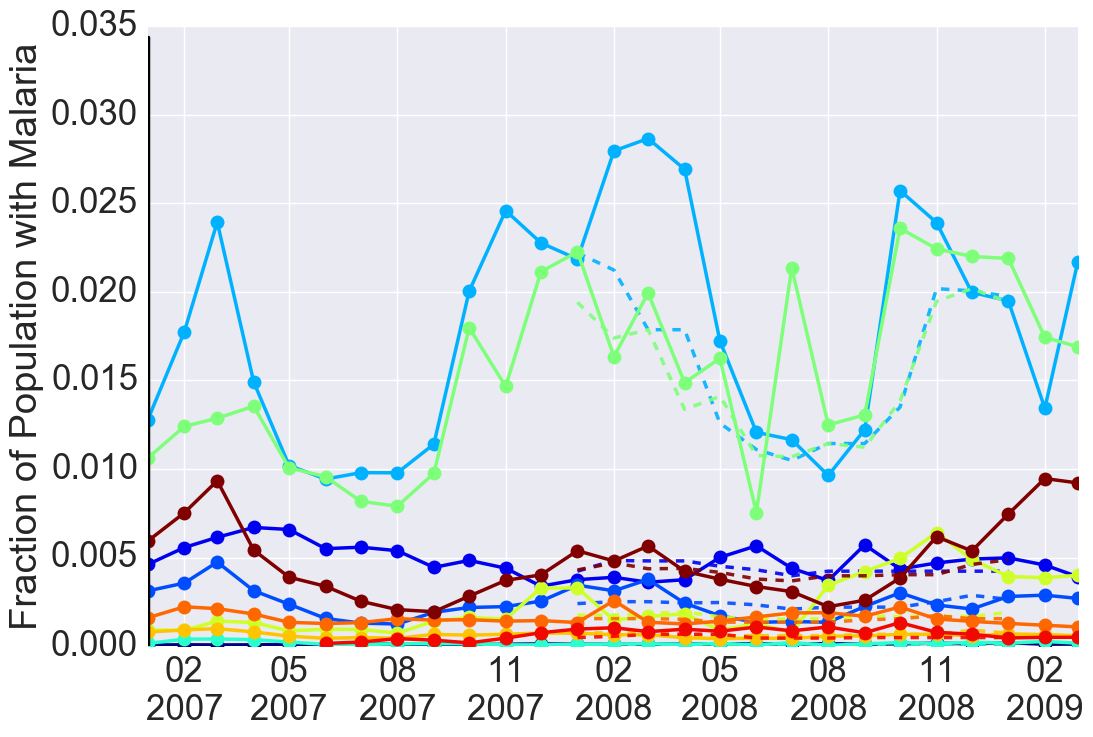

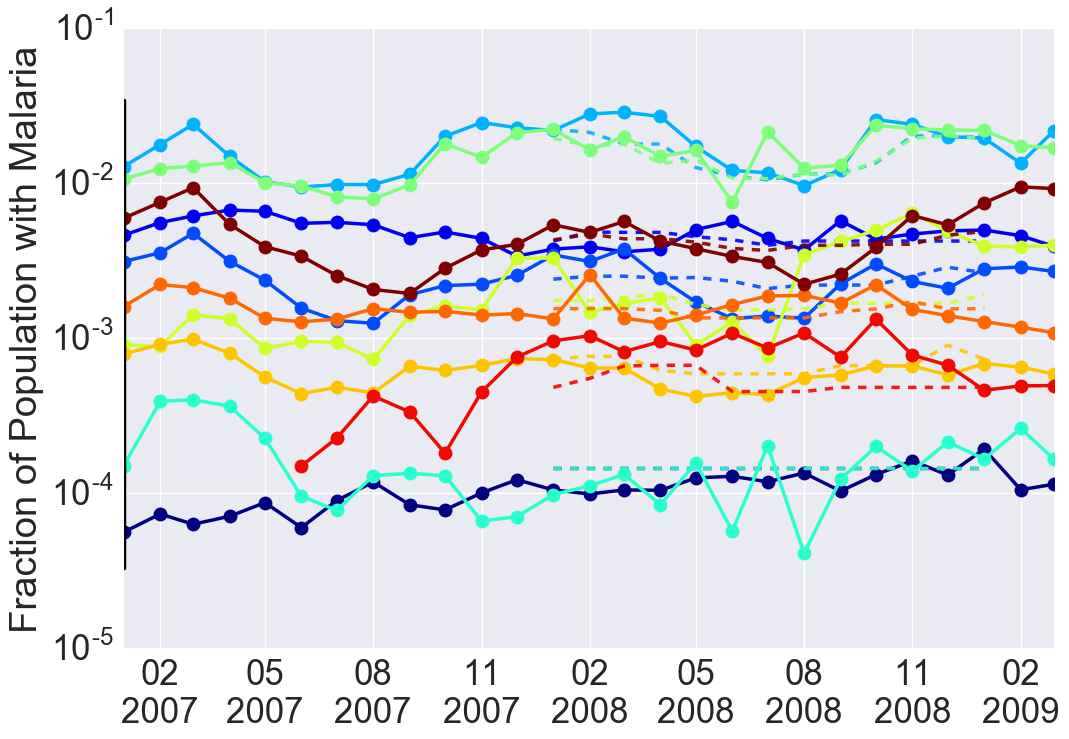

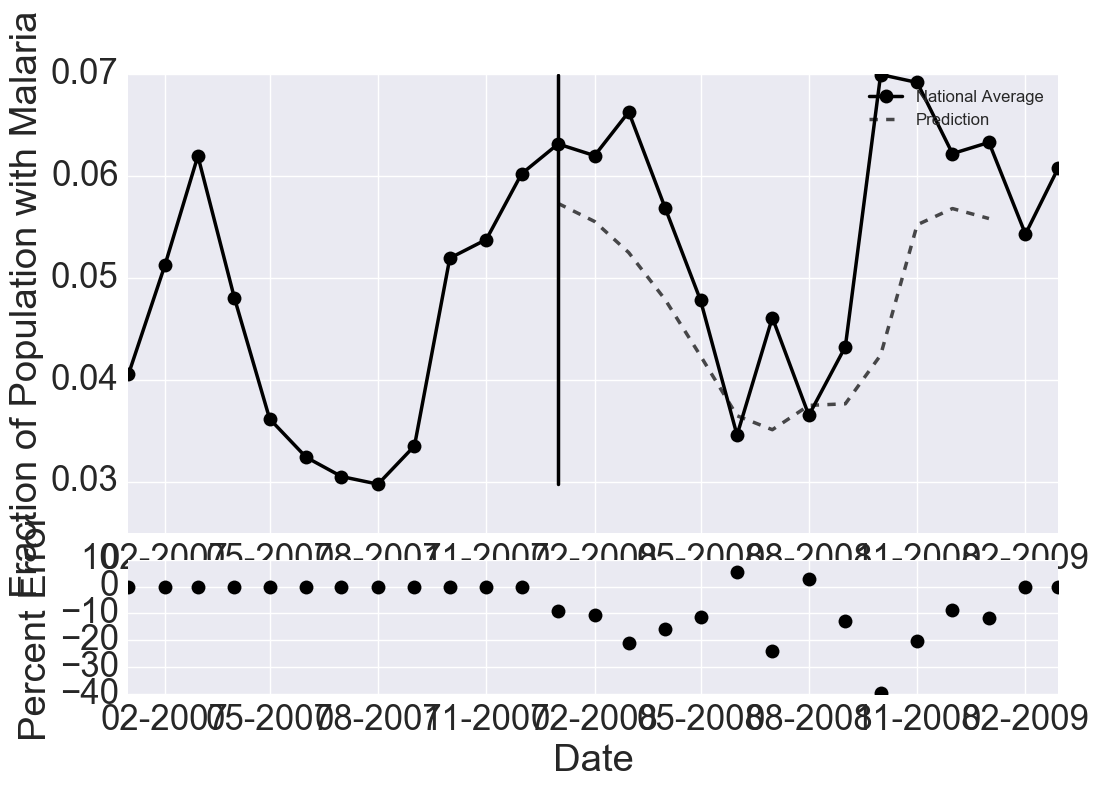

In [39]:
RMSE_zone = plot_testing(DF_shift, indicator, val_name='infection_rate', pred_name = 'prediction', train_year = 2007, logscale = True, show_leg=False, ylab='Fraction of Population with Malaria')
RMSE_zone = plot_testing(DF_shift, indicator, val_name='infection_rate', pred_name = 'prediction', train_year = 2007, logscale = False, ylab='Fraction of Population with Malaria')
to_plot, predict_plot, RMSE_n = plot_testing_nation(DF_shift, indicator, val_name='infection_rate', pred_name = 'prediction', train_year = 2007, ylab='Fraction of Population with Malaria')

# year long forecasting
ext_DF = forecast(DF_training, RF, n_months=12)
RMSE_zone_for = plot_forcasting(DF_shift, ext_DF, indicator, val_name='infection_rate', train_year = 2007, logscale = False, show_leg=False, ylab='Fraction of Population with Malaria')
RMSE_zone_for = plot_forcasting(DF_shift, ext_DF, indicator, val_name='infection_rate', train_year = 2007, logscale = True, show_leg=False, ylab='Fraction of Population with Malaria')
to_plot, predict_plot, RMSE_n_for = plot_forcast_nation(DF_shift, ext_DF, indicator, val_name='infection_rate', train_year = 2007, ylab='Fraction of Population with Malaria')


In [512]:
print RMSE_n
RMSE_zone

0.160079841079


[(u'addis ababa', 0.9470899410663336),
 (u'afar', 0.2106713201373584),
 (u'amhara', 0.2681847977036646),
 (u'benishangul-gumuz', 0.32156660857780839),
 (u'dire dawa', 0.70000975463353388),
 (u'gambella', 0.27443925264178171),
 (u'harreri', 0.592473393815516),
 (u'oromiya', 0.2856400370446458),
 (u'snnpr', 0.25967673164499794),
 (u'somali', 0.41393652823952309),
 (u'tigray', 0.24841747229596811)]

In [513]:
RMSE_n_for

0.16023354304700468

<h1> Train on all data and project one year </h1>

<h1> confidence interval </h1>

In [14]:
def pred_ints(model, X, percentile=95):
    err_down = []
    err_up = []
    for features in X:
        preds = []
        for pred in model.estimators_:
            preds.append(pred.predict(features.reshape(1, -1))[0])
        err_down.append(np.percentile(preds, (100 - percentile) / 2. ))
        err_up.append(np.percentile(preds, 100 - (100 - percentile) / 2.))
    return err_down, err_up

<h1> claculate error one month out, prevent overfitting </h1>

<h1> build several models to prevent overfitting</h1>

<h3> National level average error </h3>

In [135]:
DF_testing[DF_testing['Indicator'] == indicators[4]].groupby('Real_Date').sum()\
    .groupby(level=0).apply(lambda x: (x.val - x.prediction) / x.val)

Real_Date   Real_Date 
2016-03-10  2016-03-10    0.088250
2016-04-09  2016-04-09   -0.099377
2016-05-09  2016-05-09   -0.086817
2016-06-08  2016-06-08    0.096752
2016-07-08  2016-07-08   -0.131112
2016-08-07  2016-08-07   -0.236065
2016-09-06  2016-09-06   -0.064478
2016-10-11  2016-10-11    0.037721
2016-11-10  2016-11-10   -0.129093
2016-12-10  2016-12-10   -0.258281
2017-01-09  2017-01-09   -0.190523
dtype: float64

<h3> Natinoal all indicators. RMSE on testing set </h3>

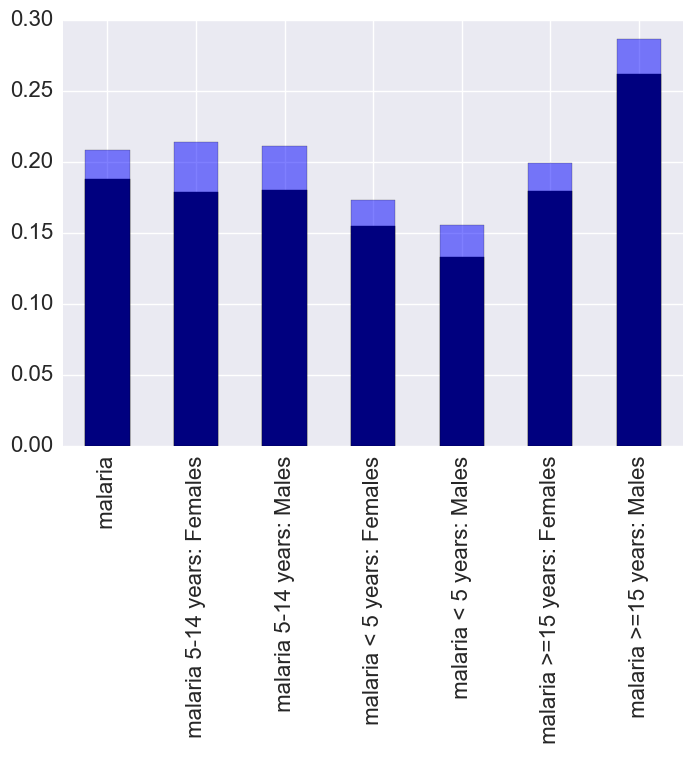

In [703]:
DF_testing = pd.concat(tests[3], ignore_index=True)

# Sum over all the regions that make up the national indicator... after the sum, groupby by level 0
nation_rmse = DF_testing.groupby(['Indicator', 'Real_Date']).sum()\
    .groupby(level=0).apply(lambda x: np.sqrt((((x.val - x.prediction_m_18) / x.val)**2).mean()))
    
nation_rmse.index = [val.split('for')[-1] for val in nation_rmse.index]
nation_rmse.plot.bar(color = 'k', alpha=1)

#################################################################
DF_testing = pd.concat(tests[2], ignore_index=True)

# Sum over all the regions that make up the national indicator... after the sum, groupby by level 0
nation_rmse = DF_testing.groupby(['Indicator', 'Real_Date']).sum()\
    .groupby(level=0).apply(lambda x: np.sqrt((((x.val - x.prediction_m_12) / x.val)**2).mean()))
    
nation_rmse.index = [val.split('for')[-1] for val in nation_rmse.index]
#nation_rmse.plot.bar(color='r', alpha=0.5)

#################################################################
DF_testing = pd.concat(tests[1], ignore_index=True)

# Sum over all the regions that make up the national indicator... after the sum, groupby by level 0
nation_rmse = DF_testing.groupby(['Indicator', 'Real_Date']).sum()\
    .groupby(level=0).apply(lambda x: np.sqrt((((x.val - x.prediction_m_6) / x.val)**2).mean()))
    
nation_rmse.index = [val.split('for')[-1] for val in nation_rmse.index]
nation_rmse.plot.bar(color='b', alpha=0.5)

<h1> Regional level RMSE </h1>

In [688]:
# Sum over all the regions that make up the national indicator... after the sum, groupby by level 0
region_rmse = DF_testing.groupby(['Region', 'Indicator'])\
    .apply(lambda x: np.sqrt((((x.val - x.prediction_m_12) / x.val)**2).mean()))

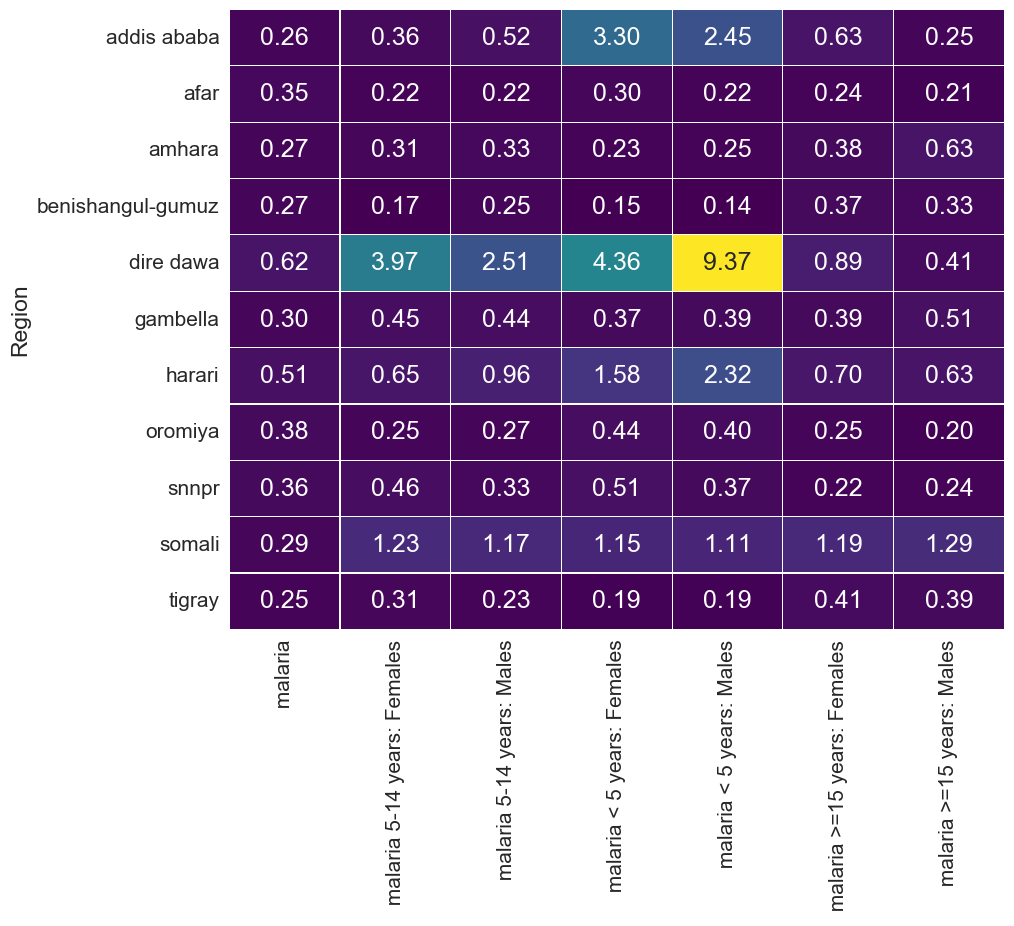

In [689]:
result = region_rmse.reset_index().pivot(index='Region', columns='Indicator', values=0).replace(np.nan,0)
result.columns=[val.split('for')[-1] for val in result.columns]
fig=figure()
fig.set_size_inches(10, 8)
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.heatmap(result, annot=True, fmt=".2f", cmap='viridis', label='big',\
            square=False,linewidths=0.1, cbar=False) #ListedColormap(['red','green', 'red']) #vmin=0,vmax=1.5
#plt.title('{:s}\n Date: {:s}'.format(title, str(ind)))
plt.show()

<h1> Make a model for each region </h1>

In [468]:
regions = DF_shift.groupby('Region').count().index
for region in regions:
    DF_training = pd.DataFrame(DF_shift[(DF_shift['E_Date'] < end_date - pd.offsets.relativedelta(months=offset)) \
                            & (DF_shift['Region'] == region)])
#DF_training

In [661]:
a = copy([1])

In [614]:
from collections import defaultdict

In [696]:
#RF = RandomForestRegressor(n_estimators=100, warm_start=False)
#RF = GradientBoostingRegressor(n_estimators=100, alpha=0.1, warm_start=True)

features = ['density','month', 'elevation_m', 'net_frac', 'temp', 'prec_mm', 'temp_delta', 'prec_delta', \
              'val_delta', 'val_shift_1', 'temp_shift_1', 'prec_shift_1', \
              'val_shift_2', 'temp_shift_2', 'prec_shift_2', 'gen_cat', 'age_cat']

#features = ['density', 'val_shift_1', 'val_delta', 'gen_cat', 'age_cat',  'prec_shift_2', 'temp_shift_2']


end_date = pd.datetime(2009,1,1)
pred_shifts = range(0, 19, 6)

trains = defaultdict(list)
tests = defaultdict(list)
shifts = []

        
for region in regions:
    DF_shift_region = pd.DataFrame(DF_shift[DF_shift['Region'] == region])
    DF_shift_region_cut = pd.DataFrame(DF_shift[DF_shift['Region'] == region])
    
    for i, offset in enumerate(pred_shifts):
        poststr = ''
        if offset != 0:
            poststr = '_m_%s' % offset
        prediction_str = 'prediction%s' % poststr
        prediction_upper_str = 'prediction_upper%s' % poststr
        prediction_lower_str = 'prediction_lower%s' % poststr
        
        # Cut on new offset
        DF_training = DF_shift_region_cut[DF_shift_region_cut['E_Date'] <= end_date - pd.offsets.relativedelta(months=offset)]
        DF_testing = DF_shift_region_cut.drop(DF_training.index)

        RF = RandomForestRegressor(n_estimators=20, warm_start=True)
        # Training:
        y = DF_training.val.values
        xtrain = DF_training[features].values
        RF.fit(xtrain, y)

        DF_training[prediction_str] = RF.predict(xtrain)
        trains[i].append(DF_training)
        #err_up, err_down = pred_ints(RF, xtrain, percentile=68)
        #DF_training[prediction_upper_str] = err_up
        #DF_training[prediction_lower_str] = err_down

        # Testing:
        xtest = DF_testing[features].values
        DF_testing[prediction_str] = RF.predict(xtest)
        tests[i].append(DF_testing)

        #Make predictions beyond 2007 to compare with data in 2008
        x_all = DF_shift_region[features].values

        DF_shift_region[prediction_str] = RF.predict(x_all)
        
    # Shifts contain all information. Split up by time and prediction postfix later
    shifts.append(DF_shift_region)

        # Recursive forecast to up to one year:
        #ext_DF, forecast_DF = forecast(DF_training, RF, n_months=12)
        
        
#DF_training = pd.concat(trains, ignore_index=True)
#DF_testing = pd.concat(tests, ignore_index=True)
DF_shift_region = pd.concat(shifts, ignore_index=True)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [680]:
DF_training = pd.concat(trains[2], ignore_index=True)
DF_testing = pd.concat(tests[2], ignore_index=True)

In [682]:
tests[2][0].columns

Index([u'Real_Date', u'Indicator_id', u'val', u'Region', u'Indicator',
       u'RegionLat', u'RegionLon', u'gen_cat', u'age_cat', u'E_Date',
       u'E_year', u'E_month', u'month', u'year', u'capital', u'pop',
       u'density', u'ave_temp', u'ave_prec_mm', u'elevation_m',
       u'infection_rate', u'is_capital', u'net_frac', u'prec_mm', u'temp',
       u'val_shift_1', u'infection_rate_shift_1', u'temp_shift_1',
       u'prec_shift_1', u'Region_shift_1', u'Ind_shift_1', u'temp_delta',
       u'prec_delta', u'val_shift_2', u'infection_rate_shift_2',
       u'temp_shift_2', u'prec_shift_2', u'Region_shift_2', u'Ind_shift_2',
       u'temp_delta_2', u'prec_delta_2', u'val_delta', u'infection_rate_delta',
       u'log_val', u'log_val_delta', u'log_val_shift_1', u'log_val_shift_2',
       u'log_infection_rate', u'log_infection_rate_shift_1',
       u'log_elevation_m', u'log_pop', u'log_density', u'log_prec_mm',
       u'log_prec_shift_1', u'log_prec_shift_2', u'log_prec_delta',
       u'pre

<h1> Plot training testing validation sperately </h1>

<h3> Loop through all regions + nation and indicators and make plots... then plot RMSE </h3>

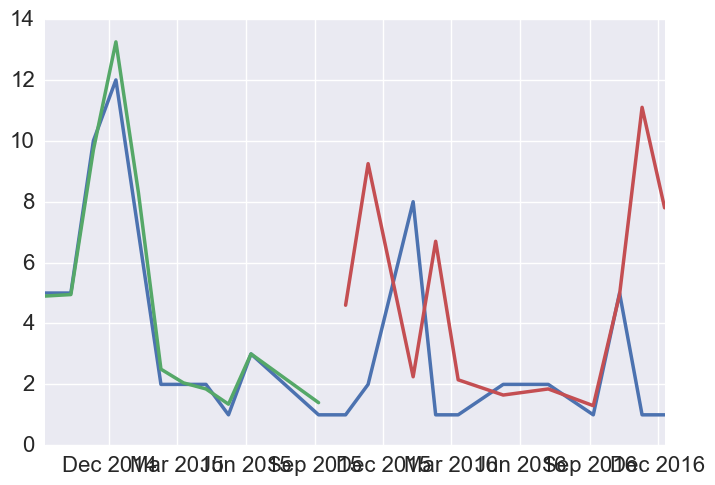

In [685]:
#plt.plot(DF_shift[DF_shift['Indicator'] == indicators[4]].groupby('Real_Date').sum().val)
plt.plot(DF_shift_region[(DF_shift_region['Indicator'] == indicators[3]) & (DF_shift_region['Region'] == 'dire dawa')].groupby('Real_Date').sum().val)
plt.plot(DF_training[(DF_training['Indicator'] == indicators[3]) & (DF_training['Region'] == 'dire dawa')].groupby('Real_Date').sum().prediction_m_12)
plt.plot(DF_testing[(DF_testing['Indicator'] == indicators[3]) & (DF_testing['Region'] == 'dire dawa')].groupby('Real_Date').sum().prediction_m_12)
#plt.plot(DF_testing[(DF_testing['Indicator'] == indicators[0]) & (DF_testing['Region'] == 'dire dawa')].groupby('Real_Date').sum().prediction_m_12)

In [603]:
DF_testing[(DF_testing['Indicator'] == indicators[0]) & (DF_testing['Region'] == 'dire dawa')]\
[['val', 'prediction', 'prediction_m_6', 'prediction_m_12']]

val  prediction  prediction_m_6  prediction_m_12
823   43.0   42.666667       44.600000        39.133333
824   49.0   85.066667       84.966667        91.533333
825   58.0   50.066667       59.100000        62.766667
826   37.0   46.166667       51.000000        49.033333
827   69.0   30.433333       30.200000        31.166667
828   25.0   49.566667       46.200000        51.633333
829   89.0   23.733333       25.566667        25.700000
830   18.0   66.200000       57.200000        63.666667
831   54.0   28.600000       34.300000        33.433333
832   88.0   52.833333       50.700000        54.733333
833   61.0   66.500000       66.500000        68.700000
834   94.0   36.233333       49.833333        45.233333
835   73.0   70.966667       78.866667        89.300000
836  119.0  126.333333      114.600000       126.066667
837   69.0  105.000000       99.333333       112.600000
838   54.0   65.533333       70.933333        74.100000
839   40.0   33.066667       37.200000        35.566667

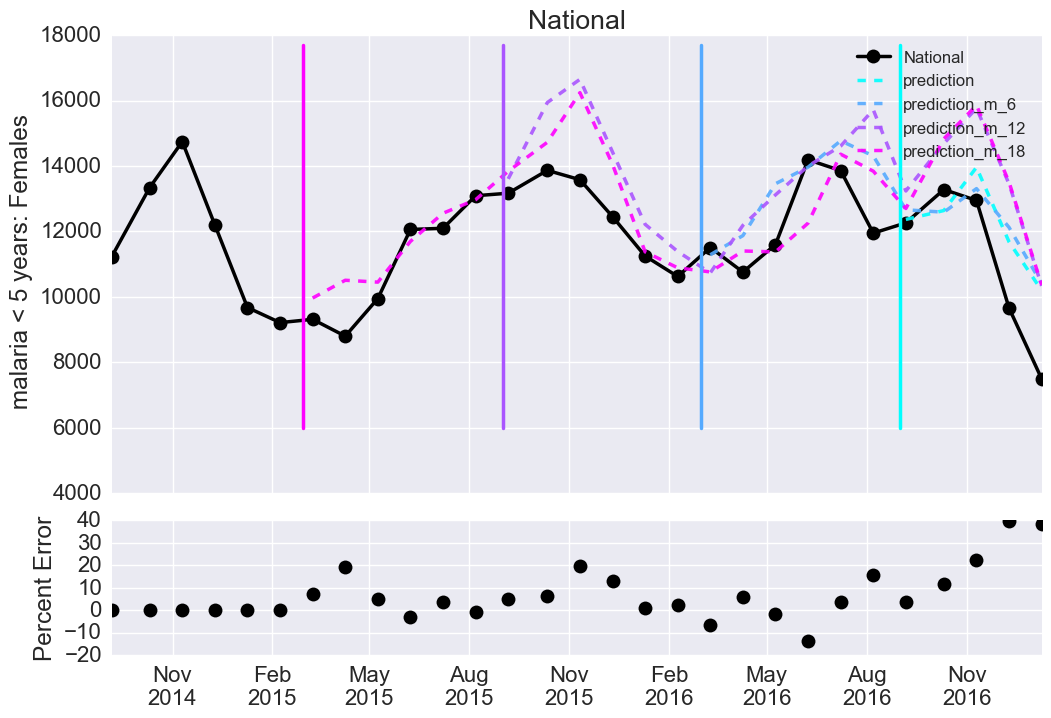

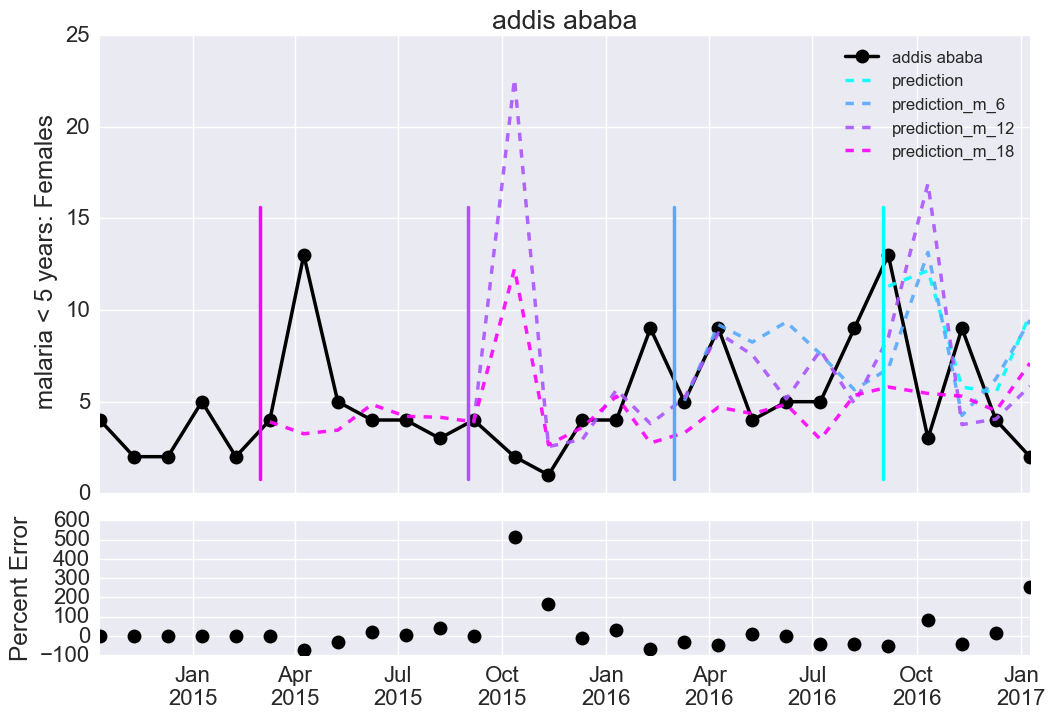

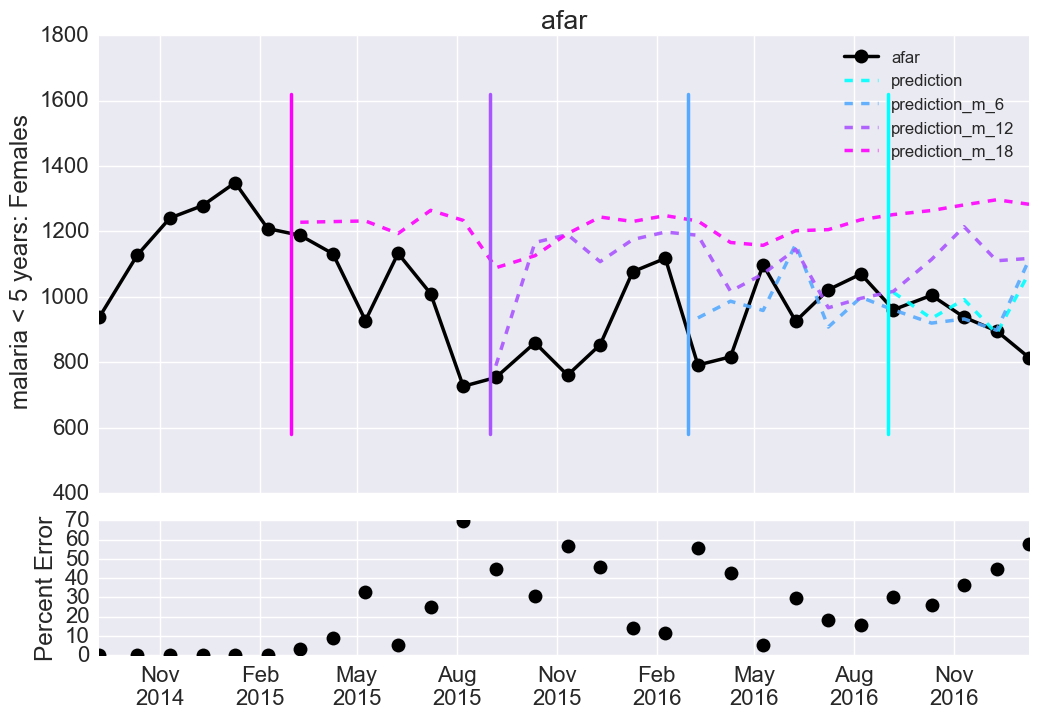

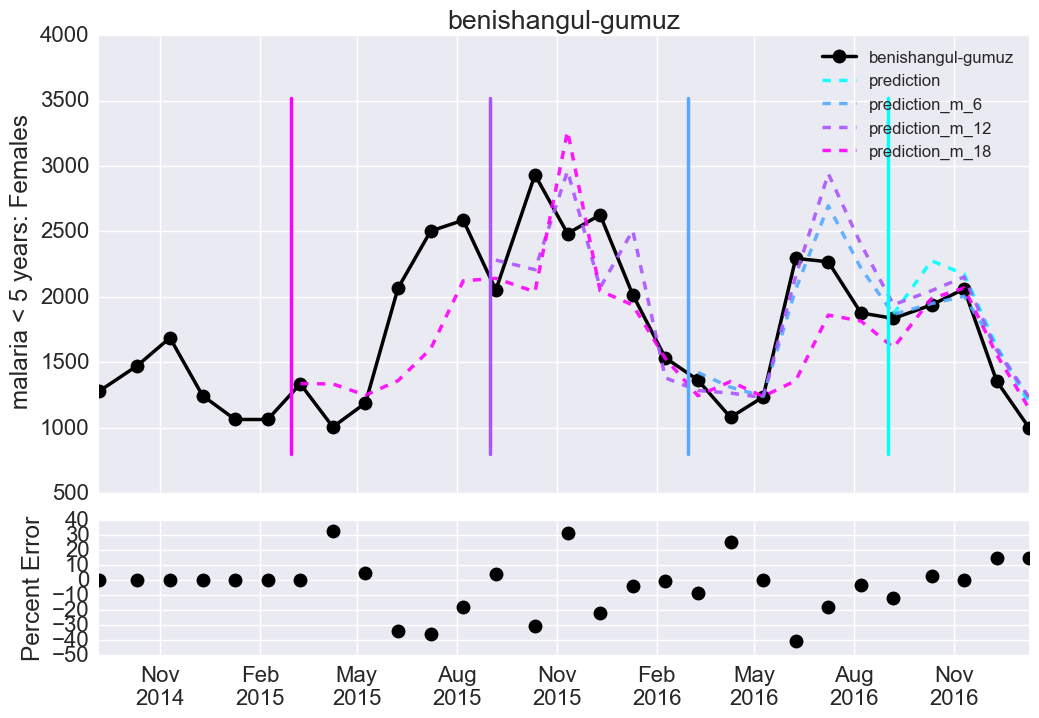

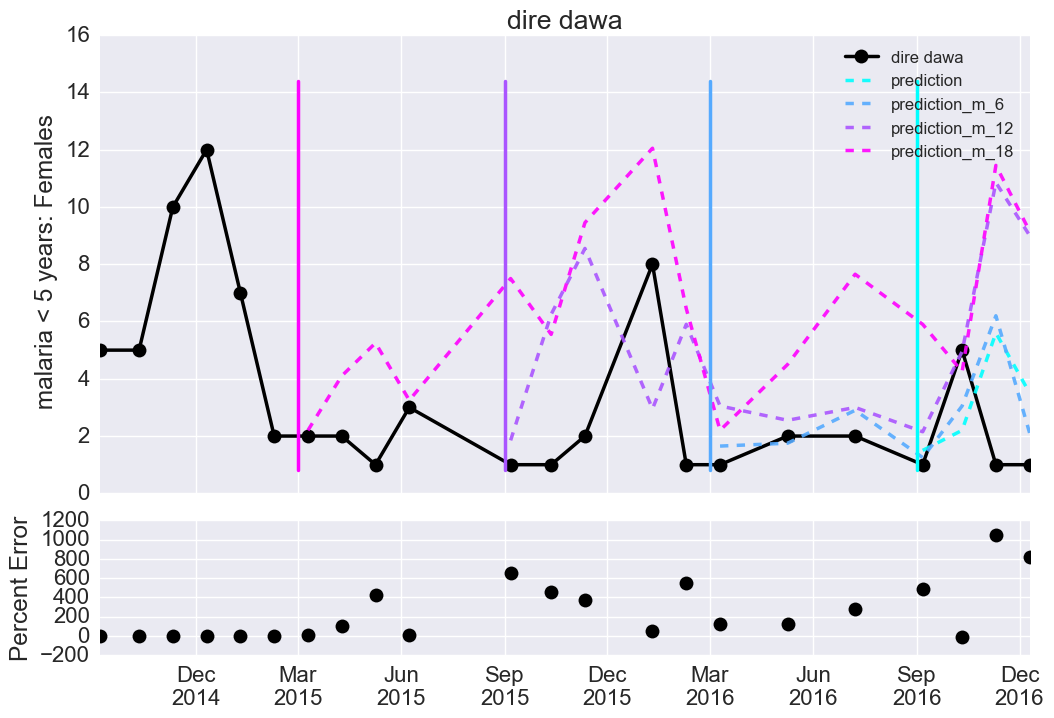

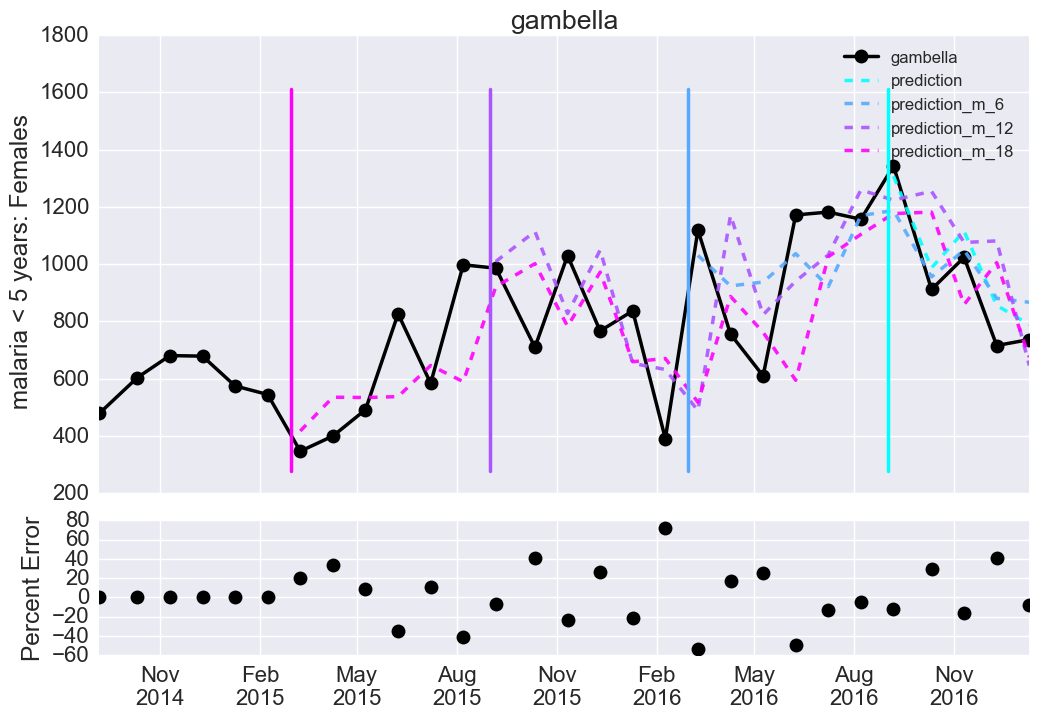

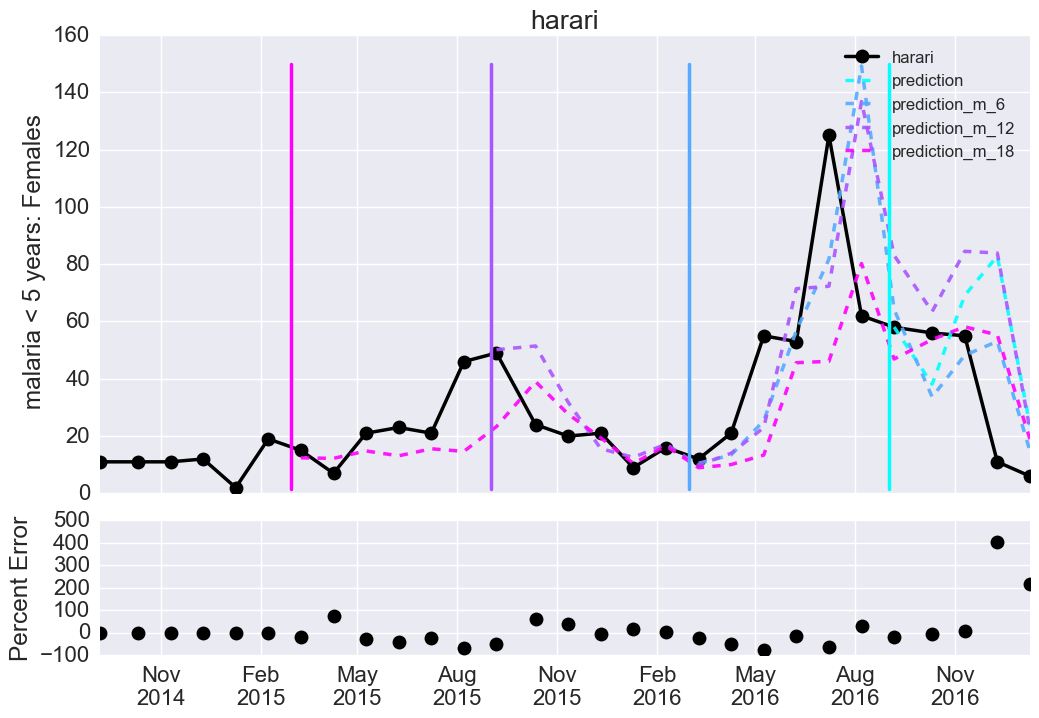

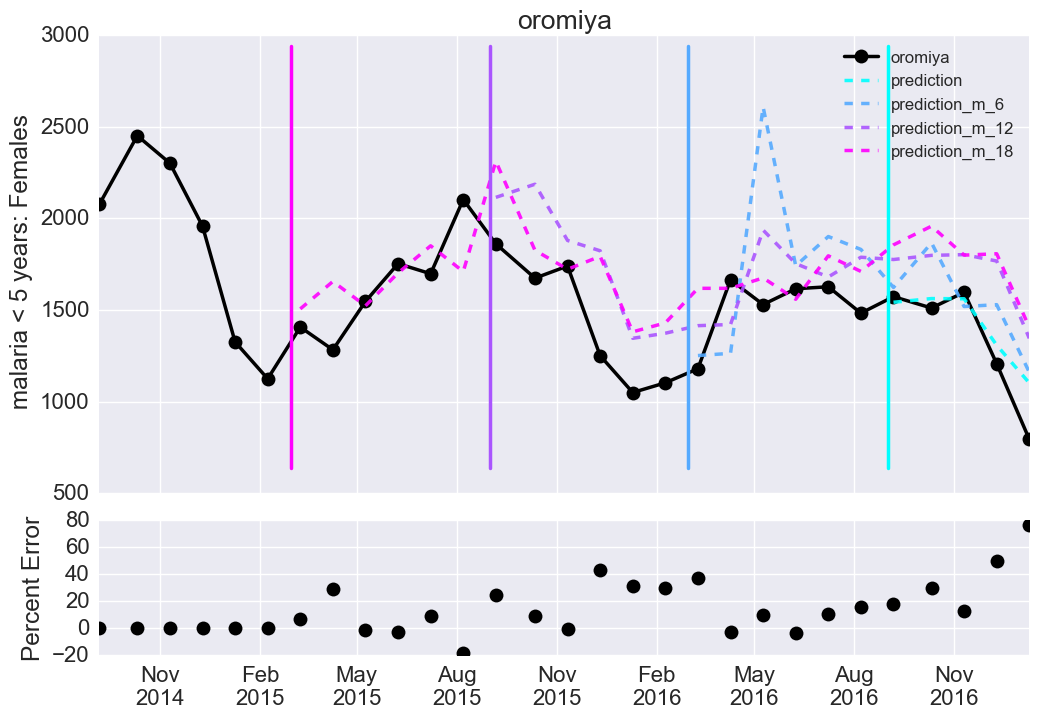

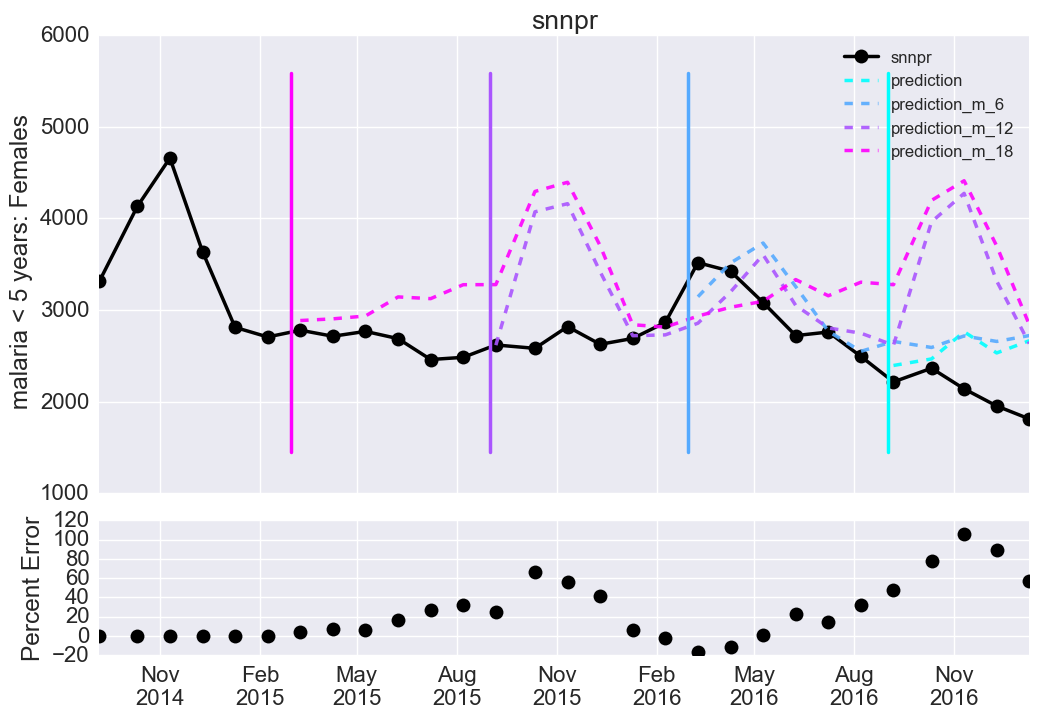

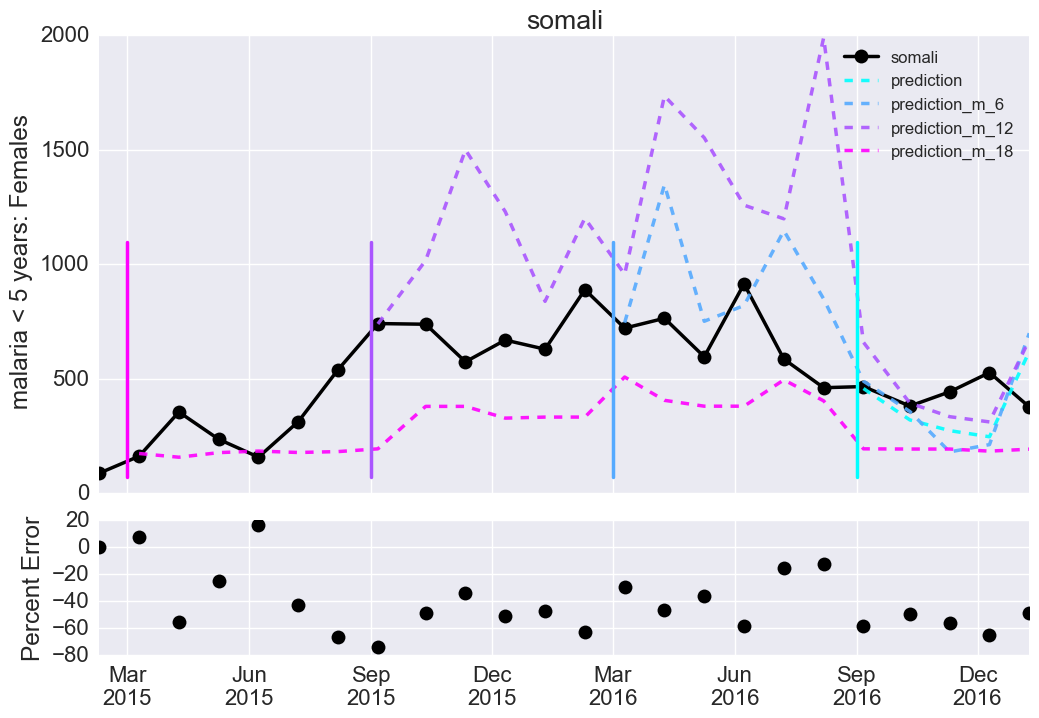

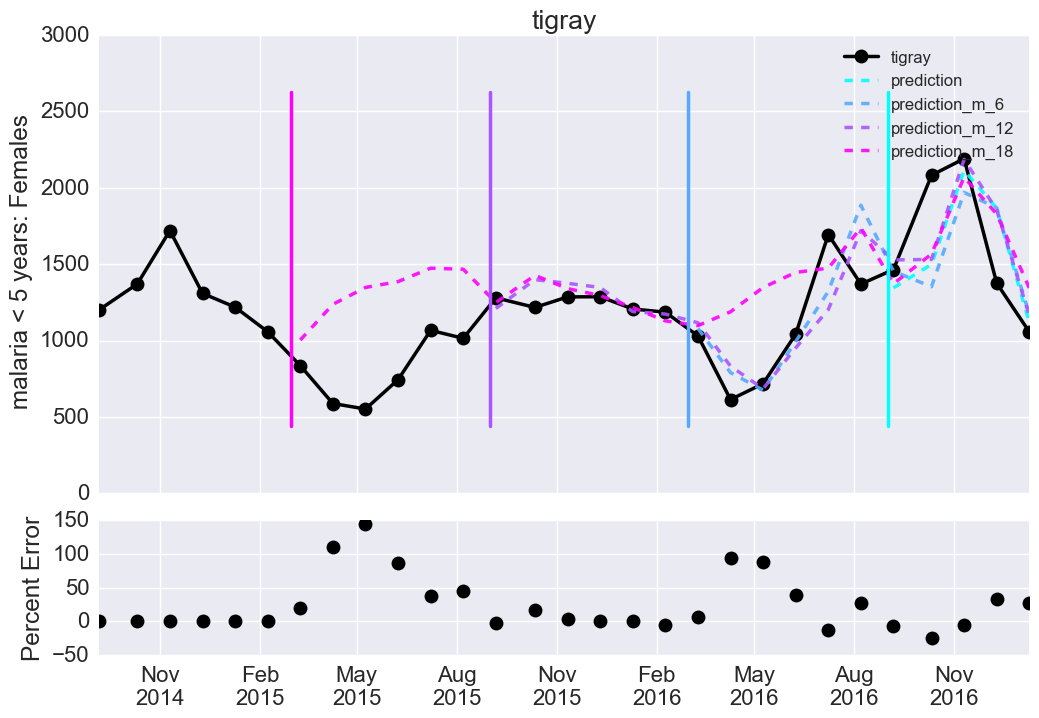

In [714]:
#RMSE_zone = plot_testing(DF_shift, indicator, date_type='Real_Date', val_name='val', pred_name = 'prediction', train_year = 2006, horz_line = (2016,9), logscale = False)

horz_lines = [(2016,9), (2016,3), (2015,9), (2015,3)]

indiator = indicators[3]

to_plot, predict_plot, RMSE_n = plot_testings_nation(DF_shift_region, indiator, date_type='Real_Date', val_name='val',\
                    pred_name = 'prediction', pred_shifts=pred_shifts, training_end = (2008, 12),  \
                    horz_lines = horz_lines[:4], cf_band=False, cmap=cm.cool, title = 'National')

for region in regions:
    to_plot, predict_plot, RMSE_n = plot_testings_nation(DF_shift_region[DF_shift_region['Region']==region], \
                    indiator, date_type='Real_Date', val_name='val',\
                    pred_name = 'prediction', pred_shifts=pred_shifts, training_end = (2008, 12),  \
                    horz_lines = horz_lines[:4], cf_band=False, cmap=cm.cool, title=region)
    plt.savefig('malaria_1m_testing/%s.png' % region)


<h1> Predicting Malaria Count </h1>

<h1> Simplified model </h1> 

In [348]:
RF = RandomForestRegressor(n_estimators=100, warm_start=True)
#RF = GradientBoostingRegressor(learning_rate=.1, n_estimators=1000)

In [354]:
#train on 2007 data
DF_training = DF_shift[DF_shift['E_Date'] < pd.datetime(2008,1,1)]
DF_testing = DF_shift.drop(DF_training.index)

# Sample indicies randomly:
#DF_training = DF_shift.loc[DF_shift['E_year'] < 2009].sample(frac=0.6, replace=False)
#DF_testing = DF_shift.loc[DF_shift['E_year'] < 2009].drop(DF_training.index)

#all data
#DF_training = DF_shift

In [355]:
features = ['density','month', 'elevation_m', 'net_frac', 'temp', 'prec_mm', 'temp_delta', 'prec_delta', \
              'val_delta', 'val_shift_1', 'temp_shift_1', 'prec_shift_1', \
              'val_shift_2', 'temp_shift_2', 'prec_shift_2', 'gen_cat', 'age_cat']

#features = ['pop','density','month', 'elevation_m', 'net_frac', 'temp', 'prec_mm', 'temp_delta', 'prec_delta', \
#              'val_delta', 'val_shift_1', 'temp_shift_1', 'prec_shift_1', \
#              'val_shift_2', 'temp_shift_2', 'prec_shift_2', 'gen_cat', 'age_cat']
# Training:
y = DF_training.val.values
xtrain = DF_training[features].values
RF.fit(xtrain, y)

DF_training['prediction'] = RF.predict(xtrain)
err_up, err_down = pred_ints(RF, xtrain, percentile=68)
DF_training['prediction_upper'] = err_up
DF_training['prediction_lower'] = err_down

# Testing:
xtest = DF_testing[features].values
DF_testing['prediction'] = RF.predict(xtest)
err_up, err_down = pred_ints(RF, xtest, percentile=68)
DF_testing['prediction_upper'] = err_up
DF_testing['prediction_lower'] = err_down


#Make predictions beyond 2007 to compare with data in 2008
x_all = DF_shift[features].values

DF_shift['prediction'] = RF.predict(x_all)
err_up, err_down = pred_ints(RF, x_all, percentile=68)
DF_shift['prediction_upper'] = err_up
DF_shift['prediction_lower'] = err_down



/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

In [356]:
# compare prediction to values (RMSE validation)

In [462]:
feature_imp = RF.feature_importances_
sorted_index = sorted(range(len(feature_imp)),key=lambda x:feature_imp[x], reverse=True)

xx = range(len(feature_imp))
plt.bar(xx, feature_imp[sorted_index])
xticks(xx, [features[i] for i in sorted_index], rotation = 'vertical')
ylabel('Feature Importance')
yscale('log')

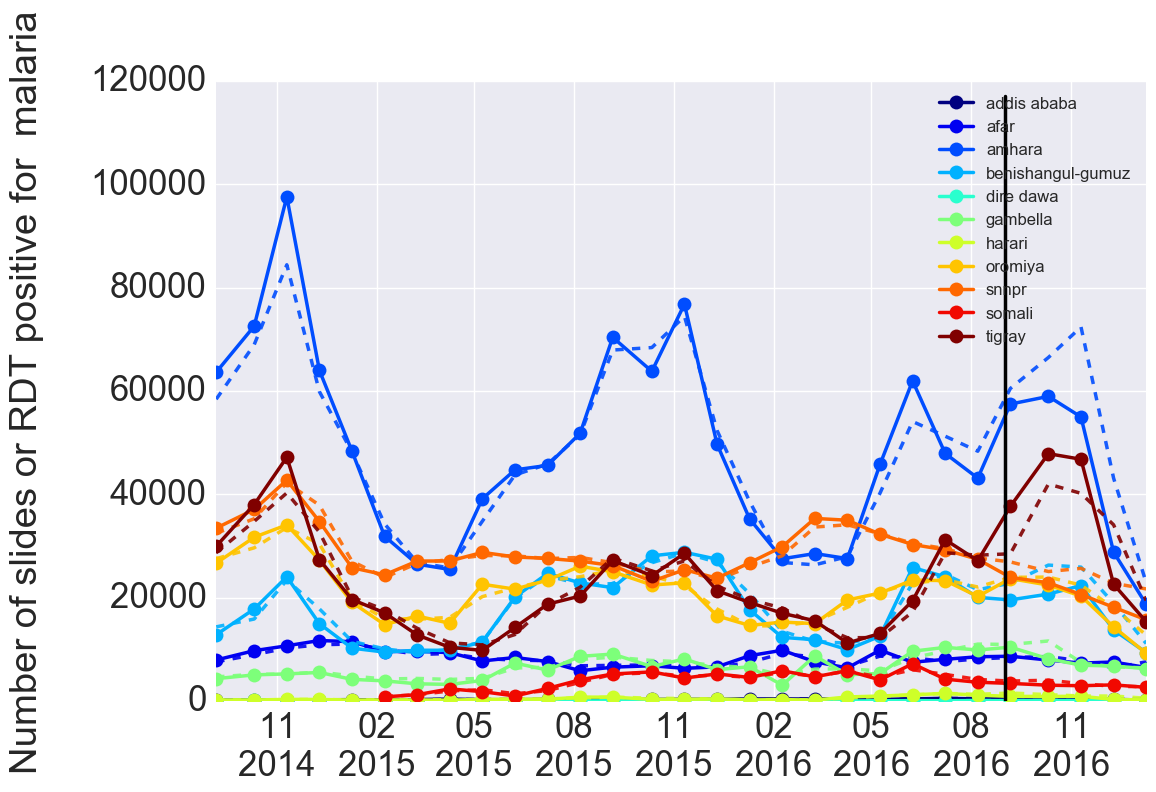

In [358]:
RMSE_zone = plot_testing(DF_shift, indicator, date_type='Real_Date', val_name='val', pred_name = 'prediction', train_year = 2006, horz_line = (2016,9), logscale = False)
to_plot, predict_plot, RMSE_n = plot_testing_nation(DF_shift, indicator, date_type='Real_Date', val_name='val', pred_name = 'prediction', train_year = 2006,  horz_line = (2016,9), cf_band=True)

NameError: name 'forecast' is not defined

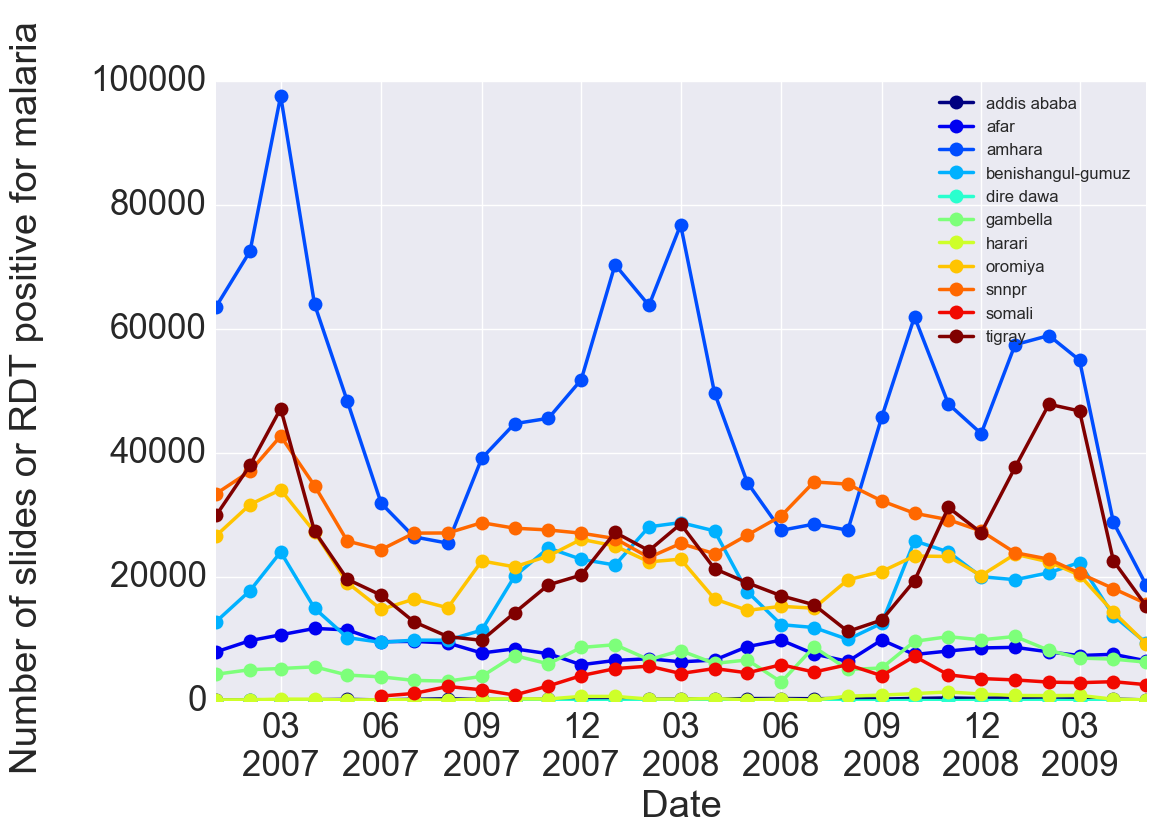

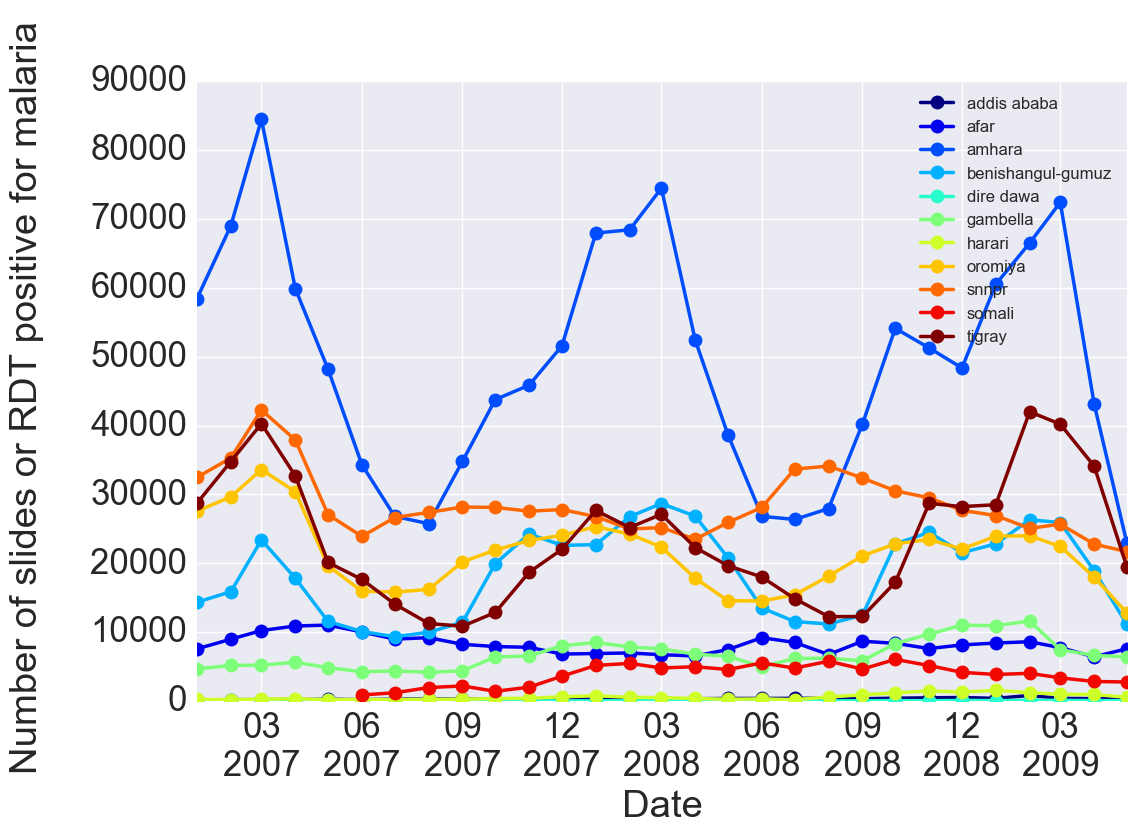

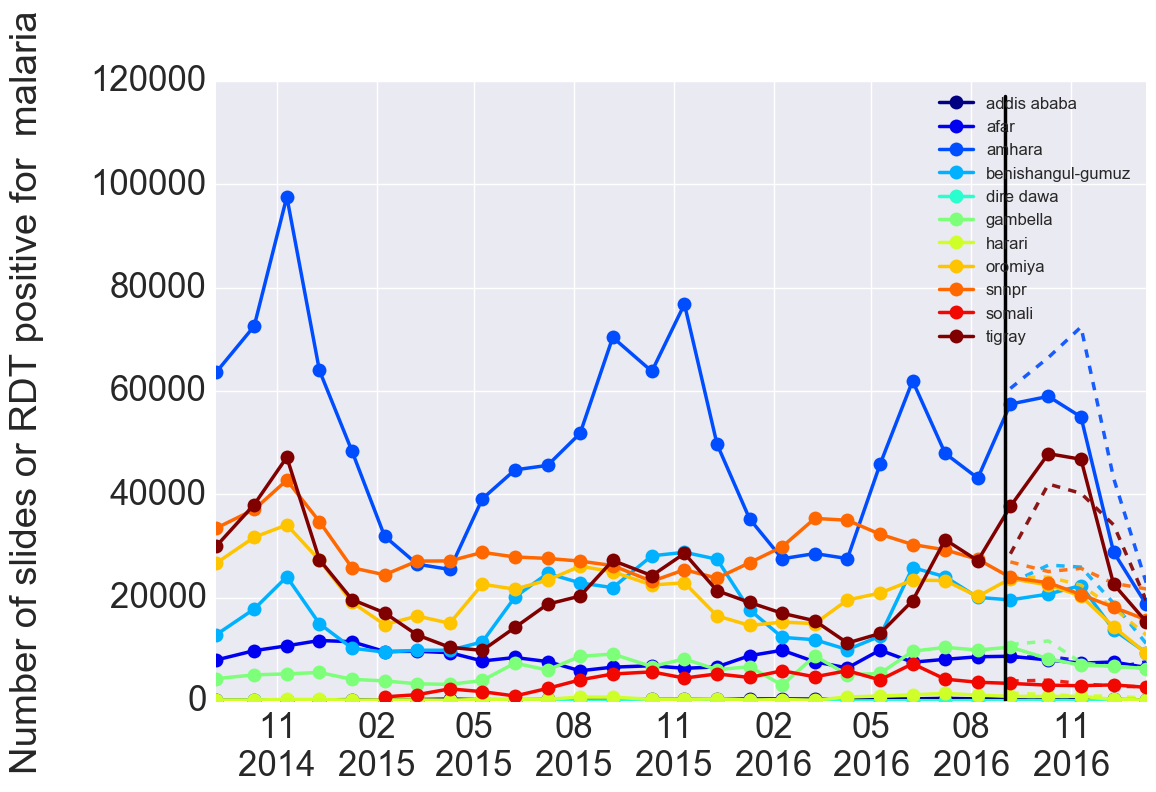

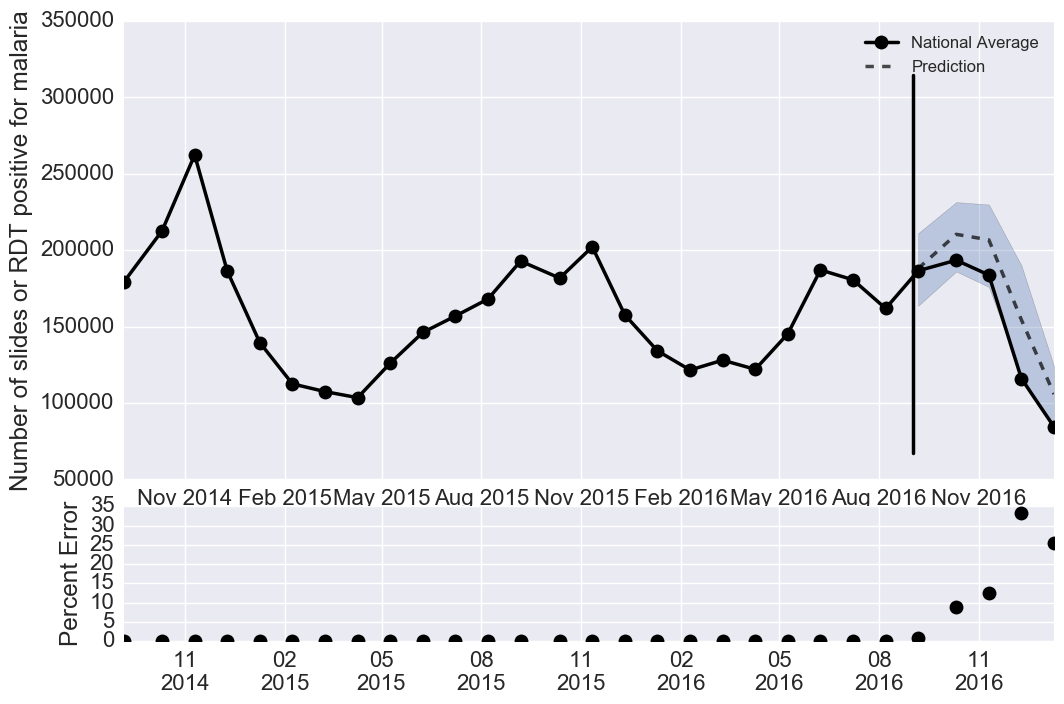

In [359]:
indicator = 'Number of slides or RDT positive for malaria'
series_plot = plot_date_indicator(DF_shift, indicator, val_name='val')
series_d = plot_date_indicator(DF_shift, indicator, val_name='prediction')

RMSE_zone = plot_testing(DF_shift, indicator, date_type='Real_Date', val_name='val', pred_name = 'prediction', train_year = 2008, horz_line = (2016,9), logscale = True, show_leg=False)
RMSE_zone = plot_testing(DF_shift, indicator, date_type='Real_Date', val_name='val', pred_name = 'prediction', train_year = 2008, horz_line = (2016,9), logscale = False)
to_plot, predict_plot, RMSE_n = plot_testing_nation(DF_shift, indicator, date_type='Real_Date', val_name='val', pred_name = 'prediction', train_year = 2008,  horz_line = (2016,9), cf_band=True)

# Forecast from the end of the training data. Does not include the predictions from DF_shift
ext_DF, forecast_DF = forecast(DF_training, RF, n_months=12)
# 1 year forcasting
RMSE_zone = plot_forcasting(DF_shift, ext_DF, indicator, val_name='val', train_year = 2008, logscale = True, show_leg=False)
to_plot, predict_plot, RMSE_n_for = plot_forcast_nation(DF_shift, ext_DF, indicator, val_name='val', train_year = 2008)


In [65]:
RMSE_n_for

0.24384330691978454

In [99]:
ext_DF.reset_index().groupby('Real_Date').count()

E_Date  val  Indicator  gen_cat  age_cat  E_year  E_month  month  \
Real_Date                                                                      
2014-08-07       6    6          6        6        6       6        6      6   
2014-09-11      69   69         69       69       69      69       69     69   
2014-10-11      70   70         70       70       70      70       70     70   
2014-11-10      70   70         70       70       70      70       70     70   
2014-12-10      70   70         70       70       70      70       70     70   
2015-01-09      70   70         70       70       70      70       70     70   
2015-02-08      77   77         77       77       77      77       77     77   
2015-03-10      77   77         77       77       77      77       77     77   
2015-04-09      77   77         77       77       77      77       77     77   
2015-05-09      77   77         77       77       77      77       77     77   
2015-06-08      77   77         77       77       77      77       77     77   
2015-07-08      75   75         75       75       75      75       75     75   
2015-08-07      76   76         76       76       76      76       76     76   
2015-09-12      77   77         77       77       77      77       77     77   
2015-10-12      76   76         76       76       76      76       76     76   
2015-11-11      76   76         76       76       76      76       76     76   
2015-12-11      76   76         76       76       76      76       76     76   
2016-01-10      77   77         77       77       77      77       77     77   
2016-02-09      76   76         76       76       76      76       76     76   
2016-03-10      75   75         75       75       75      75       75     75   
2016-04-09      74   74         74       74       74      74       74     74   
2016-05-09      76   76         76       76       76      76       76     76   
2016-06-08      75   75         75       75       75      75       75     75   
2016-07-08      77   77         77       77       77      77       77     77   
2016-08-07      76   76         76       76       76      76       76     76   
2016-09-11      77   77         77       77       77      77       77     77   
2016-10-11      77   77         77       77       77      77       77     77   
2016-11-10      77   77         77       77       77      77       77     77   
2016-12-10      77   77         77       77       77      77       77     77   
2017-01-09      77   77         77       77       77      77       77     77   
2017-02-08      77   77         77       77       77      77       77     77   
2017-03-10      77   77         77       77       77      77       77     77   
2017-04-09      77   77         77       77       77      77       77     77   
2017-05-09      77   77         77       77       77      77       77     77   
2017-06-08      77   77         77       77       77      77       77     77   
2017-07-08      77   77         77       77       77      77       77     77   
2017-08-07      77   77         77       77       77      77       77     77   
2017-09-11      77   77         77       77       77      77       77     77   
2017-10-11      77   77         77       77       77      77       77     77   
2017-11-10      77   77         77       77       77      77       77     77   
2017-12-10      76   76         76       76       76      76       76     76   

            year  capital   ...    log_density  log_prec_mm  log_prec_shift_1  \
Real_Date                   ...                                                 
2014-08-07     6        6   ...              6            6                 6   
2014-09-11    69       69   ...             69           69                69   
2014-10-11    70       70   ...             70           70                70   
2014-11-10    70       70   ...             70           70                70   
2014-12-10    70       70   ...             70           70                70   
2015

In [71]:
RMSE_n

0.050513294898222226

<h3> Average RMSE by zone </h3>

In [305]:
mean([val[1] for val in RMSE_zone])

0.39372372155003726

In [363]:
RMSE_zone

[(u'addis ababa', 0.4239058309228913),
 (u'afar', 0.22196805348941517),
 (u'amhara', 0.18514306811832315),
 (u'benishangul-gumuz', 0.38495702097887813),
 (u'dire dawa', 0.51745941509276139),
 (u'gambella', 0.40300024325087747),
 (u'harreri', 0.67906638558338417),
 (u'oromiya', 0.27511932944625578),
 (u'snnpr', 0.31642424292375732),
 (u'somali', 0.41412514213258272),
 (u'tigray', 0.19235698996560896)]

<h1> 2015 value in 2016 </h1>

In [323]:
DF_shift.loc[(DF_shift['Indicator']==ind) & (DF_shift['E_year']==2007)]

Indicator_id      val    Region  \
Real_Date                                            
2014-09-11  hmis_indicator_4531    210.0   harreri   
2014-10-11  hmis_indicator_4531    205.0   harreri   
2014-11-10  hmis_indicator_4531    328.0   harreri   
2014-12-10  hmis_indicator_4531    309.0   harreri   
2015-01-09  hmis_indicator_4531    199.0   harreri   
2015-02-08  hmis_indicator_4531    221.0   harreri   
2015-03-10  hmis_indicator_4531    218.0   harreri   
2015-04-09  hmis_indicator_4531    169.0   harreri   
2015-05-09  hmis_indicator_4531    325.0   harreri   
2015-06-08  hmis_indicator_4531    375.0   harreri   
2015-07-08  hmis_indicator_4531    352.0   harreri   
2015-08-07  hmis_indicator_4531    761.0   harreri   
2014-09-11  hmis_indicator_4531   7938.0      afar   
2014-10-11  hmis_indicator_4531   9585.0      afar   
2014-11-10  hmis_indicator_4531  10580.0      afar   
2014-12-10  hmis_indicator_4531  11538.0      afar   
2015-01-09  hmis_indicator_4531  11339.0      afar   
2015-02-08  hmis_indicator_4531   9475.0      afar   
2015-03-10  hmis_indicator_4531   9618.0      afar   
2015-04-09  hmis_indicator_4531   9277.0      afar   
2015-05-09  hmis_indicator_4531   7654.0      afar   
2015-06-08  hmis_indicator_4531   8334.0      afar   
2015-07-08  hmis_indicator_4531   7577.0      afar   
2015-08-07  hmis_indicator_4531   5823.0      afar   
2014-09-11  hmis_indicator_4531  63575.0    amhara   
...                         ...      ...       ...   
2015-08-07  hmis_indicator_4531  26307.0     snnpr   
2014-09-11  hmis_indicator_4531  29972.0    tigray   
2014-10-11  hmis_indicator_4531  38035.0    tigray   
2014-11-10  hmis_indicator_4531  47187.0    tigray   
2014-12-10  hmis_indicator_4531  27384.0    tigray   
2015-01-09  hmis_indicator_4531  19658.0    tigray   
2015-02-08  hmis_indicator_4531  17069.0    tigray   
2015-03-10  hmis_indicator_4531  12789.0    tigray   
2015-04-09  hmis_indicator_4531  10409.0    tigray   
2015-05-09  hmis_indicator_4531   9807.0    tigray   
2015-06-08  hmis_indicator_4531  14251.0    tigray   
2015-07-08  hmis_indicator_4531  18752.0    tigray   
2015-08-07  hmis_indicator_4531  20331.0    tigray   
2014-09-11  hmis_indicator_4531   4339.0  gambella   
2014-10-11  hmis_indicator_4531   5072.0  gambella   
2014-11-10  hmis_indicator_4531   5261.0  gambella   
2014-12-10  hmis_indicator_4531   5538.0  gambella   
2015-01-09  hmis_indicator_4531   4116.0  gambella   
2015-02-08  hmis_indicator_4531   3911.0  gambella   
2015-03-10  hmis_indicator_4531   3341.0  gambella   
2015-04-09  hmis_indicator_4531   3230.0  gambella   
2015-05-09  hmis_indicator_4531   3987.0  gambella   
2015-06-08  hmis_indicator_4531   7349.0  gambella   
2015-07-08  hmis_indicator_4531   5994.0  gambella   
2015-08-07  hmis_indicator_4531   8644.0  gambella   

                                               Indicator  gen_cat  age_cat  \
Real_Date                                                                    
2014-09-11  Number of slides or RDT positive for malaria        3        4   
2014-10-11  Number of slides or RDT positive for malaria        3        4   
2014-11-10  Number of slides or RDT positive for malaria        3        4   
2014-12-10  Number of slides or RDT positive for malaria        3        4   
2015-01-09  Number of slides or RDT positive for malaria        3        4   
2015-02-08  Number of slides or RDT positive for malaria        3        4   
2015-03-10  Number of slides or RDT positive for malaria        3        4   
2015-04-09  Number of slides or RDT positive for malaria        3        4   
2015-05-09  Number of slides or RDT positive for malaria        3        4   
2015-06-08  Number of slides or RDT positive for malaria        3        4   
2015-07-08  Number of slides or RDT positive for malaria        3        4   
2015-08-07  Number of slides or RDT positive for malaria        3        4   
2014-09-11  Number of slides or RDT positive for malaria        

In [318]:
DF_shift.val[(DF_shift['Indicator']==ind) & (DF_shift['E_year']==2007) & (DF_shift['E_month']==month)]

Real_Date
2014-11-10      328.0
2014-11-10    10580.0
2014-11-10    96716.0
2014-11-10      176.0
2014-11-10    24054.0
2014-11-10      206.0
2014-11-10    33157.0
2014-11-10    38622.0
2014-11-10    47187.0
2014-11-10     5261.0
Name: val, dtype: float64

In [333]:
overlap = [DF_shift.val[(DF_shift['Indicator']==ind) & (DF_shift['E_year']==2007) & (DF_shift['E_month']==month) \
               & (DF_shift['Region']==region)].values for ind,month,region \
                          in DF_shift[['Indicator','E_month','Region']].values]

In [335]:
overlap[0][0]

14.0

In [336]:
print sqrt(mean((DF_shift['val']-DF_shift['prediction'])**2))
sqrt(DF_shift.groupby('Region').mse.mean())/DF_shift.groupby('Region').mse.mean()*100

1739.6536962


Region
addis ababa          2.004740
afar                 0.171536
amhara               0.023499
benishangul-gumuz    0.056727
dire dawa            6.446471
gambella             0.132497
harreri              0.695542
oromiya              0.058907
snnpr                0.035912
somali               0.168206
tigray               0.049796
Name: mse, dtype: float64

<h1> Extrapolate 1 year </h1>

<h3> extrapolate one month at a time for each Region</h3>

In [101]:
DF_temp = DF_ind.reset_index().set_index(['Indicator_id','Region','E_Date']).sort_index(axis=0, level=[0,1,2])
DF_test = DF_temp.loc['hmis_indicator_4531'].loc['amhara']

In [115]:
DF_test

Real_Date      val                                     Indicator  \
E_Date                                                                         
2006-11-01 2014-07-08  29417.0  Number of slides or RDT positive for malaria   
2006-12-01 2014-08-07  40357.0  Number of slides or RDT positive for malaria   
2007-01-01 2014-09-11  63575.0  Number of slides or RDT positive for malaria   
2007-02-01 2014-10-11  72514.0  Number of slides or RDT positive for malaria   
2007-03-01 2014-11-10  96716.0  Number of slides or RDT positive for malaria   
2007-04-01 2014-12-10  63761.0  Number of slides or RDT positive for malaria   
2007-05-01 2015-01-09  48209.0  Number of slides or RDT positive for malaria   
2007-06-01 2015-02-08  31828.0  Number of slides or RDT positive for malaria   
2007-07-01 2015-03-10  26443.0  Number of slides or RDT positive for malaria   
2007-08-01 2015-04-09  25412.0  Number of slides or RDT positive for malaria   
2007-09-01 2015-05-09  38872.0  Number of slides or RDT positive for malaria   
2007-10-01 2015-06-08  44445.0  Number of slides or RDT positive for malaria   
2007-11-01 2015-07-08  45462.0  Number of slides or RDT positive for malaria   
2007-12-01 2015-08-07  51797.0  Number of slides or RDT positive for malaria   
2008-01-01 2015-09-12  70126.0  Number of slides or RDT positive for malaria   
2008-02-01 2015-10-12  63670.0  Number of slides or RDT positive for malaria   
2008-03-01 2015-11-11  76693.0  Number of slides or RDT positive for malaria   
2008-04-01 2015-12-11  49436.0  Number of slides or RDT positive for malaria   
2008-05-01 2016-01-10  34889.0  Number of slides or RDT positive for malaria   
2008-06-01 2016-02-09  27232.0  Number of slides or RDT positive for malaria   
2008-07-01 2016-03-10  28299.0  Number of slides or RDT positive for malaria   
2008-08-01 2016-04-09  27394.0  Number of slides or RDT positive for malaria   
2008-09-01 2016-05-09  45648.0  Number of slides or RDT positive for malaria   
2008-10-01 2016-06-08  61377.0  Number of slides or RDT positive for malaria   
2008-11-01 2016-07-08  47301.0  Number of slides or RDT positive for malaria   
2008-12-01 2016-08-07  42717.0  Number of slides or RDT positive for malaria   
2009-01-01 2016-09-11  57129.0  Number of slides or RDT positive for malaria   
2009-02-01 2016-10-11  58649.0  Number of slides or RDT positive for malaria   
2009-03-01 2016-11-10  54903.0  Number of slides or RDT positive for malaria   

            gen_cat  age_cat  E_year  E_month  month  year    capital  \
E_Date                                                                  
2006-11-01        3        4    2006       11      7  2014  Bahir Dar   
2006-12-01        3        4    2006       12      8  2014  Bahir Dar   
2007-01-01        3        4    2007        1      9  2014  Bahir Dar   
2007-02-01        3        4    2007        2     10  2014  Bahir Dar   
2007-03-01        3        4    2007        3     11  2014  Bahir Dar   
2007-04-01        3        4    2007        4     12  2014  Bahir Dar   
2007-05-01        3        4    2007        5      1  2015  Bahir Dar   
2007-06-01        3        4    2007        6      2  2015  Bahir Dar   
2007-07-01        3        4    2007        7      3  2015  Bahir Dar   
2007-08-01        3        4    2007        8      4  2015  Bahir Dar   
2007-09-01        3        4    2007        9      5  2015  Bahir Dar   
2007-10-01        3        4    2007       10      6  2015  Bahir Dar   
2007-11-01        3        4    2007       11      7  2015  Bahir Dar   
2007-12-01        3        4    2007       12      8  2015  Bahir Dar   
2008-01-01        3        4    2008        1      9  2015  Bahir Dar   
2008-02-01        3        4    2008        2     10  2015  Bahir Dar   
2008-03-01        3        4    2008        3     11  2015  Bahir Dar   
2008-04-01        3        4    2008        4     12  2015  Bahir Dar   
2008-05-01        3        4    2008        5      1  2016  Bahir Dar  

In [46]:
# depends on DF_weather
DF_weather = pd.read_excel('/Users/attiladobi/Documents/Ethiopia_ave_weather.xlsx', header=1).dropna(how='all').set_index(['city','Field'])
month_map = {'JAN': 1, 'FEB': 2, 'MAR': 3, 'APR': 4, 'MAY': 5, 'JUN': 6, 'JUL': 7, 'AUG': 8, 'SEP': 9, 'OCT': 10, 'NOV': 11, 'DEC': 12 }
inv_month_map = {v: k for k, v in month_map.iteritems()}

def forecast(DF_test, RF, n_months=12):
    '''Pass in DF_shift to start from last month in the data or DF_training to start at last training month
    also specify the number of months to project (n_months = 12)
    Return the extended data frame'''
    
    # Initialize empty dataframe for projection
    ext_DF = pd.DataFrame()
    forecast_DF = pd.DataFrame()
    
    # set the index to Region and Ethiopian date and sort the date index
    DF_test = DF_test.reset_index().set_index(['Indicator_id', 'Region','E_Date']).sort_index(axis=0, level=[0, 1, 2])
    
    for indicator in DF_test.index.levels[0]:
        for region in DF_test.index.levels[1]:

            DF_temp = DF_test.loc[indicator].loc[region]
            
            is_first = True

            for xx in range(n_months+1):
                last_entry = DF_temp.tail(1).reset_index()
                
                if is_first:
                    start_date = last_entry['E_Date'][0]
                    is_first = False

                x = last_entry[features].values.reshape(1,-1)

                # predict new value and CF band:
                new_val = RF.predict(x)
                err_down, err_up = pred_ints(RF, x, percentile=90)
                
                last_entry['val'] = new_val
                last_entry['val_lower'] = err_down
                last_entry['val_upper'] = err_up
                # The predicted values also go in the prediction column
                # Which was the one month out forecast before the training date
                last_entry['prediction'] = new_val
                last_entry['prediction_lower'] = err_down
                last_entry['prediction_upper'] = err_up

                # increment date
                # add one month
                last_entry['E_Date'] = last_entry['E_Date'][0] + pd.offsets.relativedelta(months=1)
                last_entry.set_index('E_Date', inplace=True)

                # replace Real_Date with incremented E_Date
                last_entry['Real_Date'] = ethiopian_date.EthiopianDateConverter.date_to_gregorian(last_entry.index[0])

                last_entry.reset_index(inplace = True)

                last_entry['E_year'] = last_entry['E_Date'][0].year
                last_entry['E_month'] = last_entry['E_Date'][0].month
                last_entry['month'] = last_entry['Real_Date'][0].month
                last_entry['year'] = last_entry['Real_Date'][0].year

                #update current weather info

                last_entry['temp'] = [DF_weather.loc[capital,'temp'][inv_month_map[month]] for capital,month in zip(last_entry['capital'],last_entry['month'])]
                last_entry['prec_mm'] = [DF_weather.loc[capital,'prec_mm'][inv_month_map[month]] for capital,month in zip(last_entry['capital'],last_entry['month'])]
                last_entry['prec_mm'] = last_entry['prec_mm'].replace(nan,0)

                # The hard part... add the extrapolations 

                last_entry['val_shift_1'] = DF_temp.iloc[-1]['val']
                last_entry['temp_shift_1'] = DF_temp.iloc[-1]['temp']
                last_entry['prec_shift_1'] = DF_temp.iloc[-1]['prec_mm']
                #DF_ext['Region_shift_1'] = DF_temp.iloc[-1]['Region']
                #DF_ext['Ind_shift_1'] = DF_temp.iloc[-1]['Indicator']
                last_entry['temp_delta'] = last_entry['temp'] - DF_temp.iloc[-1]['temp_shift_1']
                last_entry['prec_delta'] = last_entry['prec_mm'] - DF_temp.iloc[-1]['prec_shift_1']

                last_entry['val_shift_2'] = DF_temp.iloc[-2]['val']
                last_entry['temp_shift_2'] = DF_temp.iloc[-2]['temp']
                last_entry['prec_shift_2'] = DF_temp.iloc[-2]['prec_mm']
                #last_entry['Region_shift_2'] = DF_ext.shift(2)['Region']
                #last_entry['Ind_shift_2'] = DF_ext.shift(2)['Indicator']
                last_entry['val_delta'] =  (last_entry['val_shift_1'] - last_entry['val_shift_2']) / last_entry['val_shift_2']

                # tack on to the end of the DF
                last_entry.set_index('E_Date', inplace = True)
                DF_temp = DF_temp.append(last_entry)

            # add back the region name   
            DF_temp['Indicator_id'] = indicator
            DF_temp['Region'] = region
            ext_DF = pd.concat([ext_DF, DF_temp])
            forecast_DF = pd.concat([forecast_DF, DF_temp[DF_temp.index > start_date] ]) #Index is E_Date

    ext_DF.reset_index(inplace = True)   
    ext_DF.set_index('Real_Date', inplace = True)
    forecast_DF.reset_index(inplace = True) 
    forecast_DF.set_index('Real_Date', inplace = True)
    
    return ext_DF, forecast_DF

<h1> Write to json or cvs </h1>

<h1> Canonical region information mapping </h1>

In [53]:
DF_region_map = pd.read_csv('/Users/attiladobi/zenysis/pipeline/auto/ethiopia/bin/shared/data/region_mapped.csv', \
                           float_precision='high', dtype={'RegionLat': np.float128, 'RegionLon': np.float128})
DF_region_map['RegionName_lower'] = [name.lower() for name in DF_region_map['RegionName']]
DF_region_map.set_index('RegionName_lower', inplace=True)
                                     

In [54]:
DF_region_map

RegionName  RegionLat  RegionLon        match_0  \
RegionName_lower                                                            
addis ababa              Addis Ababa   8.980483  38.785538            NaN   
afar                            Afar  12.036445  40.772735          Affar   
amhara                        Amhara  11.564952  38.043536  amhara ( 03 )   
benishangul-gumuz  Benishangul-Gumuz  10.502924  35.440307            b/g   
dire dawa                  Dire Dawa   9.606269  42.003027      dere dawa   
gambella                    Gambella   7.683850  34.336754          gamb.   
harari                        Harari   9.289660  42.172526          harar   
oromiya                      Oromiya   7.323567  38.660525         ormoia   
snnpr                          SNNPR   6.465809  36.806469      s.n.n.p.r   
somali                        Somali   6.932778  43.329883       somaliya   
tigray                        Tigray  13.777115  38.438673            NaN   

                       match_1           match_2            match_3  \
RegionName_lower                                                      
addis ababa                NaN               NaN                NaN   
afar                       NaN               NaN                NaN   
amhara                     NaN               NaN                NaN   
benishangul-gumuz  beneshangul  beneshangul gumu  beneshangul gumuz   
dire dawa             diredewa               NaN                NaN   
gambella               gambela               NaN                NaN   
harari                  hareri           harreri                NaN   
oromiya                 oromia            oromya            oromyia   
snnpr                     snnp            snnprs                NaN   
somali                     NaN               NaN                NaN   
tigray                     NaN               NaN                NaN   

                        match_4      match_5            match_6  \
RegionName_lower                                                  
addis ababa                 NaN          NaN                NaN   
afar                        NaN          NaN                NaN   
amhara                      NaN          NaN                NaN   
benishangul-gumuz  beni shangul  benishangul  benishangul gumuz   
dire dawa                   NaN          NaN                NaN   
gambella                    NaN          NaN                NaN   
harari                      NaN          NaN                NaN   
oromiya                     NaN          NaN                NaN   
snnpr                       NaN          NaN                NaN   
somali                      NaN          NaN                NaN   
tigray                      NaN          NaN                NaN   

                            match_7           match_8       match_9  \
RegionName_lower                                                      
addis ababa                     NaN               NaN           NaN   
afar                            NaN               NaN           NaN   
amhara                          NaN               NaN           NaN   
benishangul-gumuz  benishangul gumz  benishangul-gumz  benishangule   
dire dawa                       NaN               NaN           NaN   
gambella                        NaN               NaN           NaN   
harari                          NaN               NaN           NaN   
oromiya                         NaN               NaN           NaN   
snnpr                           NaN               NaN           NaN   
somali                          NaN               NaN           NaN   
tigray                          NaN               NaN           NaN   

                     match_10          match_11           match_12 match_13  \
RegionName_lower                                                              
addis ababa               NaN               NaN                NaN      NaN   
afar                      NaN               NaN                NaN 

In [55]:
pd.options.display.float_format = '{:20,.5f}'.format
DF_region_map['RegionLat'].astype(np.float128)

RegionName_lower
addis ababa                      8.98048
afar                            12.03645
amhara                          11.56495
benishangul-gumuz               10.50292
dire dawa                        9.60627
gambella                         7.68385
harari                           9.28966
oromiya                          7.32357
snnpr                            6.46581
somali                           6.93278
tigray                          13.77711
Name: RegionLat, dtype: float128

In [56]:
lat_lon_map = { 'Addis Ababa': (8.980483001254077, 38.78553834507309), 
'Afar': (12.036445063176075, 40.772735414805204),
'Amhara': (11.5649524790046, 38.04353615460529),
'Benishangul-Gumuz': (10.502924415157686, 35.44030701966273),
'Dire Dawa': (9.606269193503696, 42.003026894902156),
'Gambella':(7.683850454124325, 34.33675414861345),
'Harari': (9.289660023774802, 42.172525872858124),
'Oromiya': (7.323567398452454, 38.66052453790127),
'Somali': (6.932778405509416, 43.32988331430246),
'SNNPR': (6.465808724769859, 36.806469462905675),
'Tigray': (13.777114742142253, 38.43867332133363 ),  
}    
    

<h1> format the data into json for injestion </h1>

In [ ]:
ext_DF

In [57]:
# only forecast_DF
# onlt ext
Formatted_DF = ext_DF[['val', 'prediction',  'Region', 'Indicator_id']].rename(columns = \
                                {'Indicator_id': 'field', 'Region': 'RegionName'})
#Harreri update
#Formatted_DF.loc[Formatted_DF['RegionName'] == 'harreri']['RegionName'] = 'harari'

Formatted_DF['RegionName'] = [region if region != 'harreri' else 'harari' for region in Formatted_DF['RegionName']]

Formatted_DF['field'] = ['forecast_%s' % (field) for field in Formatted_DF['field']]
Formatted_DF.index = pd.DatetimeIndex(Formatted_DF.index)


# Overwrite the lowercased region name with the canonical value
Formatted_DF['RegionName'] = [DF_region_map.loc[region]['RegionName'] for region in Formatted_DF['RegionName']]

Formatted_DF['source'] ='forecast'
Formatted_DF['Real_Date'] = [date.strftime('%Y-%m-%d') for date in Formatted_DF.index]

'''
Formatted_DF['RegionLat'] = [DF_region_map.loc[region]['RegionLat'] for region in Formatted_DF['RegionName']]
Formatted_DF['RegionLon'] = [DF_region_map.loc[region]['RegionLon'] for region in Formatted_DF['RegionName']]
#finally overwrite the lowercased region name with the canonical value
Formatted_DF['RegionName'] = [DF_region_map.loc[region]['RegionName'] for region in Formatted_DF['RegionName']]

Formatted_DF['source'] ='forecast'
Formatted_DF['Real_Date'] = [date.strftime('%Y-%m-%d') for date in Formatted_DF.index]

Formatted_DF['RegionLat'] = [lat_lon_map[region][0] for region in Formatted_DF['RegionName']]
Formatted_DF['RegionLon'] = [lat_lon_map[region][1] for region in Formatted_DF['RegionName']]
'''

"\nFormatted_DF['RegionLat'] = [DF_region_map.loc[region]['RegionLat'] for region in Formatted_DF['RegionName']]\nFormatted_DF['RegionLon'] = [DF_region_map.loc[region]['RegionLon'] for region in Formatted_DF['RegionName']]\n#finally overwrite the lowercased region name with the canonical value\nFormatted_DF['RegionName'] = [DF_region_map.loc[region]['RegionName'] for region in Formatted_DF['RegionName']]\n\nFormatted_DF['source'] ='forecast'\nFormatted_DF['Real_Date'] = [date.strftime('%Y-%m-%d') for date in Formatted_DF.index]\n\nFormatted_DF['RegionLat'] = [lat_lon_map[region][0] for region in Formatted_DF['RegionName']]\nFormatted_DF['RegionLon'] = [lat_lon_map[region][1] for region in Formatted_DF['RegionName']]\n"

In [2594]:
#Formatted_DF['val'] = Formatted_DF['val'].map(lambda x: float(x))

Formatted_DF.to_csv('Malaria_Forecast_2009.csv')
Formatted_DF.to_json('Malaria_Forecast_2009.json', orient='records', double_precision=15)


In [89]:
Formatted_DF

val   RegionName                            field  \
Real_Date                                                                       
2014-09-06            183.00000  Addis Ababa  forecast_composite_indicator_47   
2014-10-11            240.00000  Addis Ababa  forecast_composite_indicator_47   
2014-11-10            206.00000  Addis Ababa  forecast_composite_indicator_47   
2014-12-10            232.00000  Addis Ababa  forecast_composite_indicator_47   
2015-01-09            284.00000  Addis Ababa  forecast_composite_indicator_47   
2015-02-08            196.00000  Addis Ababa  forecast_composite_indicator_47   
2015-03-10            293.00000  Addis Ababa  forecast_composite_indicator_47   
2015-04-09            386.00000  Addis Ababa  forecast_composite_indicator_47   
2015-05-09            275.00000  Addis Ababa  forecast_composite_indicator_47   
2015-06-08            255.00000  Addis Ababa  forecast_composite_indicator_47   
2015-07-08            328.00000  Addis Ababa  forecast_composite_indicator_47   
2015-08-07            399.00000  Addis Ababa  forecast_composite_indicator_47   
2015-09-06            343.00000  Addis Ababa  forecast_composite_indicator_47   
2015-10-12            323.00000  Addis Ababa  forecast_composite_indicator_47   
2015-11-11            343.00000  Addis Ababa  forecast_composite_indicator_47   
2015-12-11            341.00000  Addis Ababa  forecast_composite_indicator_47   
2016-01-10            410.00000  Addis Ababa  forecast_composite_indicator_47   
2016-02-09            420.00000  Addis Ababa  forecast_composite_indicator_47   
2016-03-10            387.00000  Addis Ababa  forecast_composite_indicator_47   
2016-04-09            441.00000  Addis Ababa  forecast_composite_indicator_47   
2016-05-09            337.00000  Addis Ababa  forecast_composite_indicator_47   
2016-06-08            431.00000  Addis Ababa  forecast_composite_indicator_47   
2016-07-08            519.00000  Addis Ababa  forecast_composite_indicator_47   
2016-08-07            428.00000  Addis Ababa  forecast_composite_indicator_47   
2016-09-11            494.04000  Addis Ababa  forecast_composite_indicator_47   
...                         ...          ...                              ...   
2015-09-06          4,313.00000       Tigray     forecast_hmis_indicator_3204   
2015-10-12          4,012.00000       Tigray     forecast_hmis_indicator_3204   
2015-11-11          4,901.00000       Tigray     forecast_hmis_indicator_3204   
2015-12-11          3,914.00000       Tigray     forecast_hmis_indicator_3204   
2016-01-10          3,528.00000       Tigray     forecast_hmis_indicator_3204   
2016-02-09          3,312.00000       Tigray     forecast_hmis_indicator_3204   
2016-03-10          3,104.00000       Tigray     forecast_hmis_indicator_3204   
2016-04-09          2,306.00000       Tigray     forecast_hmis_indicator_3204   
2016-05-09          2,964.00000       Tigray     forecast_hmis_indicator_3204   
2016-06-08          4,161.00000       Tigray     forecast_hmis_indicator_3204   
2016-07-08          6,847.00000       Tigray     forecast_hmis_indicator_3204   
2016-08-07          4,938.00000       Tigray     forecast_hmis_indicator_3204   
2016-09-11          5,517.80000       Tigray     forecast_hmis_indicator_3204   
2016-10-11          5,034.59000       Tigray     forecast_hmis_indicator_3204   
2016-11-10          5,379.66000       Tigray     forecast_hmis_indicator_3204   
2016-12-10          5,564.54000       Tigray     forecast_hmis_indicator_3204   
2017-01-09          4,672.80000       Tigray     forecast_hmis_indicator_3204   
2017-02-08          5,131.51000       Tigray     forecast_hmis_indicator_3204   
2017-03-10          4,880.56000       Tigray     forecast_hmis_indicator_3204   
2017-04-09          5,688.43000       Tigray     forecast_hmis_indicator_3204   
2017-05-09          5,230.97000       Tigray     forecast_hmis_indicator_3204   
2017-06-08          5,784.36000       Tigray     forecast_h

<h1> Write to json </h1>

In [59]:
#write to json
from collections import OrderedDict
with open("forecast.json", "w") as outfile:
    for line in Formatted_DF.iterrows():
        line = line[1]
        region = line['RegionName']
        json.dump(OrderedDict([('Real_Date', line['Real_Date']), ('RegionName', region), \
                   ('val', line['prediction']), ('field', line['field']), \
                   ('source', 'forecast'), ('RegionLat', lat_lon_map[region][0]), \
                   ('RegionLon', lat_lon_map[region][1])]), outfile)
        outfile.write('\n')

<h1> save to csv file </h1>

In [ ]:
with open('forecast.json', 'wb') as f:
        # Assuming that all dictionaries in the list have the same keys.
        headers = ['Real_Date', 'RegionName', 'val', 'val_lower', 'val_upper', 'field', 'source', 'RegionLat', 'RegionLon']
        csv_data = [headers]

        for line in Formatted_DF.iterrows():
            line = line[1]
            region = line['RegionName']
            data = [line['Real_Date'], \
                    region, \
                    line['val'], line['val_lower'], line['val_upper'],\
                    line['field'], \
                    'forecast', \
                    lat_lon_map[region][0], \
                    lat_lon_map[region][1]]
            csv_data.append(data)

        writer = csv.writer(f)
        writer.writerows(csv_data)

<h1> update values for new month and new prediction </h1>

In [1432]:
DF_temp = DF_temp.append(last_entry)

In [1461]:
add_one_month(DF_temp.tail(1).index[0])

datetime.datetime(2009, 3, 1, 0, 0)

In [1528]:
#DF_temp.tail(1).index = add_one_month(DF_temp.tail(1).index[0])

In [ ]:
DF_temp.tail(1)

In [139]:
pd.compat?

In [1343]:
series_d.index.levels[0]

Index([u'addis ababa', u'afar', u'amhara', u'benishangul-gumuz', u'dire dawa',
       u'gambella', u'harreri', u'oromiya', u'snnpr', u'somali', u'tigray'],
      dtype='object', name=u'Region')

<h1> Extrapolate for 1 year </h1>

In [1347]:
ext_range = pd.date_range('1/1/2009', periods=12, freq='M')
ext_dates = [set_to_first_of_month(date) for date in ext_range]

In [1378]:
DF_ext = pd.DataFrame(ext_dates, columns = ['E_Date'])

In [1379]:
DF_ext['Real_Date'] = [ethiopian_date.EthiopianDateConverter.date_to_gregorian(date) for date in DF_ext['E_Date']]
#DF_ext['Real_Date'] = [pd.datetime(date) for date in DF_ext['Real_Date']]

In [1380]:
region = series_d.index.levels[0][0]
DF_ext['Region'] = region

In [1381]:
DF_ext

E_Date   Real_Date       Region
0   2009-01-01  2016-09-11  addis ababa
1   2009-02-01  2016-10-11  addis ababa
2   2009-03-01  2016-11-10  addis ababa
3   2009-04-01  2016-12-10  addis ababa
4   2009-05-01  2017-01-09  addis ababa
5   2009-06-01  2017-02-08  addis ababa
6   2009-07-01  2017-03-10  addis ababa
7   2009-08-01  2017-04-09  addis ababa
8   2009-09-01  2017-05-09  addis ababa
9   2009-10-01  2017-06-08  addis ababa
10  2009-11-01  2017-07-08  addis ababa
11  2009-12-01  2017-08-07  addis ababa

In [1382]:
DF_ext['E_Date']

0     2009-01-01
1     2009-02-01
2     2009-03-01
3     2009-04-01
4     2009-05-01
5     2009-06-01
6     2009-07-01
7     2009-08-01
8     2009-09-01
9     2009-10-01
10    2009-11-01
11    2009-12-01
Name: E_Date, dtype: object

In [1383]:
#DF_ext['E_Date'] = DF_ext['E_Date'].astype(datetime64)
DF_ext.set_index('Real_Date', inplace=True)
DF_ext.index = DF_ext.index.astype(datetime64)
DF_ext['E_year'] = [val.year for val in DF_ext['E_Date']]
DF_ext['E_month'] = [val.month for val in DF_ext['E_Date']]
DF_ext['month'] = DF_ext.index.month
DF_ext['year'] = DF_ext.index.year

<h3> set indicator name </h3>

In [1385]:
DF_ext['Indicator'] = indicator

In [1386]:
DF_ext

E_Date       Region  E_year  E_month  month  year  \
Real_Date                                                           
2016-09-11  2009-01-01  addis ababa    2009        1      9  2016   
2016-10-11  2009-02-01  addis ababa    2009        2     10  2016   
2016-11-10  2009-03-01  addis ababa    2009        3     11  2016   
2016-12-10  2009-04-01  addis ababa    2009        4     12  2016   
2017-01-09  2009-05-01  addis ababa    2009        5      1  2017   
2017-02-08  2009-06-01  addis ababa    2009        6      2  2017   
2017-03-10  2009-07-01  addis ababa    2009        7      3  2017   
2017-04-09  2009-08-01  addis ababa    2009        8      4  2017   
2017-05-09  2009-09-01  addis ababa    2009        9      5  2017   
2017-06-08  2009-10-01  addis ababa    2009       10      6  2017   
2017-07-08  2009-11-01  addis ababa    2009       11      7  2017   
2017-08-07  2009-12-01  addis ababa    2009       12      8  2017   

                                               Indicator  
Real_Date                                                 
2016-09-11  Number of slides or RDT positive for malaria  
2016-10-11  Number of slides or RDT positive for malaria  
2016-11-10  Number of slides or RDT positive for malaria  
2016-12-10  Number of slides or RDT positive for malaria  
2017-01-09  Number of slides or RDT positive for malaria  
2017-02-08  Number of slides or RDT positive for malaria  
2017-03-10  Number of slides or RDT positive for malaria  
2017-04-09  Number of slides or RDT positive for malaria  
2017-05-09  Number of slides or RDT positive for malaria  
2017-06-08  Number of slides or RDT positive for malaria  
2017-07-08  Number of slides or RDT positive for malaria  
2017-08-07  Number of slides or RDT positive for malaria

<h3> add weather and regional attributes to the data </h3>

In [1390]:
DF_ext['capital'] = [DF_pop.loc[key]['Capital'] for key in DF_ext['Region']]
DF_ext['pop'] = [DF_pop['Population'][key] for key in DF_ext['Region']]
DF_ext['density'] = [DF_pop['Density'][key] for key in DF_ext['Region']]
DF_ext['ave_temp'] = [DF_pop['ave_temp'][key] for key in DF_ext['Region']]
DF_ext['ave_prec_mm'] = [DF_pop['ave_prec_mm'][key] for key in DF_ext['Region']]
DF_ext['elevation_m'] = [DF_pop['Elevation_m'][key] for key in DF_ext['Region']]
#DF_ext['infection_rate'] = DF_ext['val'] / DF_ext['pop'] #only applies to one indicator: indicator = 'Number of slides or RDT positive for malaria'

DF_ext['net_frac'] = [DF_mean_nets.val[region] for region in DF_ext['Region']]

DF_ext['temp'] = [DF_weather.loc[capital,'temp'][inv_month_map[month]] for capital,month in zip(DF_ext['capital'],DF_ext['month'])]
DF_ext['prec_mm'] = [DF_weather.loc[capital,'prec_mm'][inv_month_map[month]] for capital,month in zip(DF_ext['capital'],DF_ext['month'])]
DF_ext['prec_mm'] = DF_ext['prec_mm'].replace(nan,0)

DF_ext['temp_cat'] = [temp_map(temp) for temp in DF_ext['temp']]
DF_ext['prec_cat'] = [prec_map(prec) for prec in DF_ext['prec_mm']]

DF_ext['val_shift_1'] = DF_ext.shift(1)['val']
DF_ext['temp_shift_1'] = DF_ext.shift(1)['temp']
DF_ext['temp_cat_shift_1'] = DF_ext.shift(1)['temp_cat']
DF_ext['prec_shift_1'] = DF_ext.shift(1)['prec_mm']
DF_ext['prec_cat_shift_1'] = DF_ext.shift(1)['prec_cat']
DF_ext['Region_shift_1'] = DF_ext.shift(1)['Region']
DF_ext['Ind_shift_1'] = DF_ext.shift(1)['Indicator']
DF_ext['temp_delta'] = DF_ext['temp'] - DF_shift['temp_shift_1']
DF_ext['prec_delta'] = DF_ext['prec_mm'] - DF_shift['prec_shift_1']

DF_ext['val_shift_2'] = DF_ext.shift(2)['val']
DF_ext['temp_shift_2'] = DF_ext.shift(2)['temp']
DF_ext['temp_cat_shift_2'] = DF_ext.shift(2)['temp_cat']
DF_ext['prec_shift_2'] = DF_ext.shift(2)['prec_mm']
DF_ext['prec_cat_shift_2'] = DF_ext.shift(2)['prec_cat']
DF_ext['Region_shift_2'] = DF_ext.shift(2)['Region']
DF_ext['Ind_shift_2'] = DF_ext.shift(2)['Indicator']

DF_ext = DF_ext.loc[(DF_ext['Region'] == DF_ext['Region_shift_1']) &\
                      (DF_ext['Indicator'] == DF_ext['Ind_shift_1']) &\
                      (DF_ext['Region'] == DF_ext['Region_shift_2']) &\
                      (DF_ext['Indicator'] == DF_ext['Ind_shift_2']) ]

In [1391]:
DF_ext

E_Date       Region  E_year  E_month  month  year  \
Real_Date                                                           
2016-09-11  2009-01-01  addis ababa    2009        1      9  2016   
2016-10-11  2009-02-01  addis ababa    2009        2     10  2016   
2016-11-10  2009-03-01  addis ababa    2009        3     11  2016   
2016-12-10  2009-04-01  addis ababa    2009        4     12  2016   
2017-01-09  2009-05-01  addis ababa    2009        5      1  2017   
2017-02-08  2009-06-01  addis ababa    2009        6      2  2017   
2017-03-10  2009-07-01  addis ababa    2009        7      3  2017   
2017-04-09  2009-08-01  addis ababa    2009        8      4  2017   
2017-05-09  2009-09-01  addis ababa    2009        9      5  2017   
2017-06-08  2009-10-01  addis ababa    2009       10      6  2017   
2017-07-08  2009-11-01  addis ababa    2009       11      7  2017   
2017-08-07  2009-12-01  addis ababa    2009       12      8  2017   

                                               Indicator      capital  \
Real_Date                                                               
2016-09-11  Number of slides or RDT positive for malaria  Addis Ababa   
2016-10-11  Number of slides or RDT positive for malaria  Addis Ababa   
2016-11-10  Number of slides or RDT positive for malaria  Addis Ababa   
2016-12-10  Number of slides or RDT positive for malaria  Addis Ababa   
2017-01-09  Number of slides or RDT positive for malaria  Addis Ababa   
2017-02-08  Number of slides or RDT positive for malaria  Addis Ababa   
2017-03-10  Number of slides or RDT positive for malaria  Addis Ababa   
2017-04-09  Number of slides or RDT positive for malaria  Addis Ababa   
2017-05-09  Number of slides or RDT positive for malaria  Addis Ababa   
2017-06-08  Number of slides or RDT positive for malaria  Addis Ababa   
2017-07-08  Number of slides or RDT positive for malaria  Addis Ababa   
2017-08-07  Number of slides or RDT positive for malaria  Addis Ababa   

                pop  density  ave_temp  ave_prec_mm  elevation_m  net_frac  \
Real_Date                                                                    
2016-09-11  3273000  5198.49      16.0       1210.0         2355  0.822821   
2016-10-11  3273000  5198.49      16.0       1210.0         2355  0.822821   
2016-11-10  3273000  5198.49      16.0       1210.0         2355  0.822821   
2016-12-10  3273000  5198.49      16.0       1210.0         2355  0.822821   
2017-01-09  3273000  5198.49      16.0       1210.0         2355  0.822821   
2017-02-08  3273000  5198.49      16.0       1210.0         2355  0.822821   
2017-03-10  3273000  5198.49      16.0       1210.0         2355  0.822821   
2017-04-09  3273000  5198.49      16.0       1210.0         2355  0.822821   
2017-05-09  3273000  5198.49      16.0       1210.0         2355  0.822821   
2017-06-08  3273000  5198.49      16.0       1210.0         2355  0.822821   
2017-07-08  3273000  5198.49      16.0       1210.0         2355  0.822821   
2017-08-07  3273000  5198.49      16.0       1210.0         2355  0.822821   

            temp  prec_mm  temp_cat  prec_cat  
Real_Date                                      
2016-09-11  16.0    180.0         0         3  
2016-10-11  16.0     20.0         0         1  
2016-11-10  15.0     10.0         0         0  
2016-12-10  15.0     10.0         0         0  
2017-01-09  16.0     10.0         0         0  
2017-02-08  17.0     30.0         0         1  
2017-03-10  17.0     60.0         0         2  
2017-04-09  17.0     80.0         0         2  
2017-05-09  18.0     80.0         0         2  
2017-06-08  17.0    130.0         0         3  
2017-07-08  15.0    260.0         0         3  
2017-08-07  16.0    280.0         0         3

In [109]:
DF_ind.groupby('Indicator').first().index

Index([u'Number of slides or RDT positive for malaria',
       u'Number of slides or RDT positive for malaria 5-14 years: Females',
       u'Number of slides or RDT positive for malaria 5-14 years: Males',
       u'Number of slides or RDT positive for malaria < 5 years: Females',
       u'Number of slides or RDT positive for malaria < 5 years: Males',
       u'Number of slides or RDT positive for malaria >=15 years: Females',
       u'Number of slides or RDT positive for malaria >=15 years: Males',
       u'Proportion of targeted HH covered with LLIN in the last 12 months',
       u'Total number of slides or RDT performed for malaria diagnosis'],
      dtype='object', name=u'Indicator')

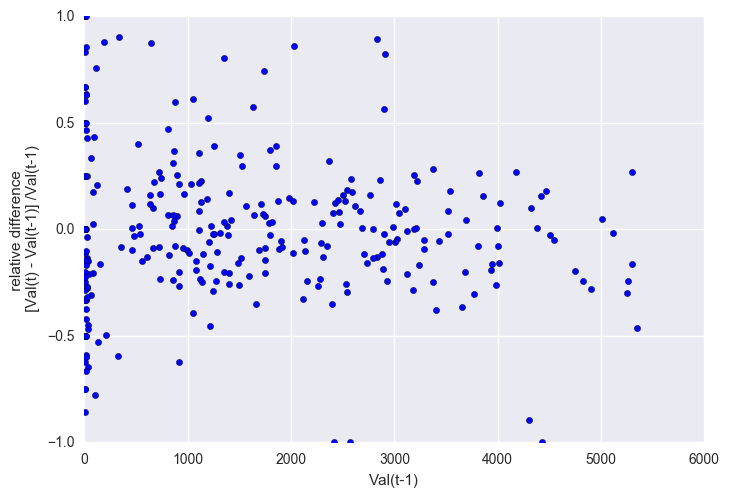

In [138]:
cur_val = DF_ind[DF_ind['Indicator'].str.contains('Number of slides or RDT positive for malaria 5-14 years: Females')]\
.val.drop(0).values[1:]

prev_val = DF_ind[DF_ind['Indicator'].str.contains('Number of slides or RDT positive for malaria 5-14 years: Females')]\
.val.drop(0).shift().values[1:]

plt.scatter(prev_val, (cur_val-prev_val)/prev_val)
#xscale('log')
#yscale('log')
ylim([-1,1])
xlim([-1,6000])
xlabel('Val(t-1)')
ylabel(' relative difference \n [Val(t) - Val(t-1)] /Val(t-1)' )

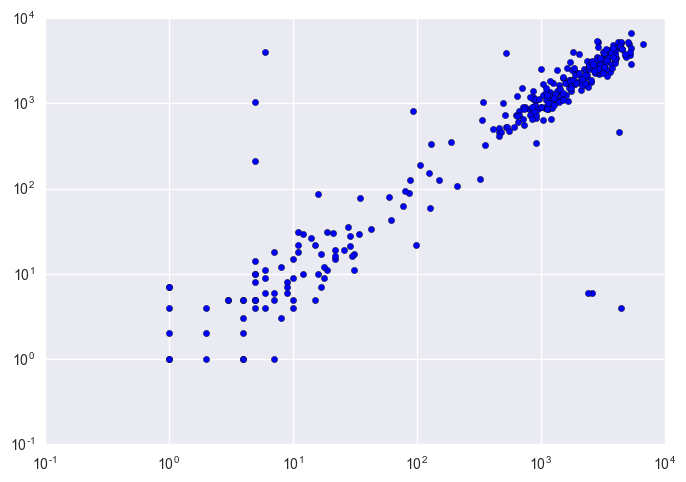